**Исследование датасета с данными о продлении/отказа от продления полисов ОСАГО**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import os
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


Загружаем датасет

In [2]:
df=pd.read_csv('Data.txt', sep=';')
               #чтобы правильно открыть разделим с помощью sep где знаки=;

In [3]:
df.shape

(96605, 30)

In [4]:
df.head(10)

,DATA_TYPE,POLICY_ID,POLICY_BEGIN_MONTH,POLICY_END_MONTH,POLICY_IS_RENEWED,POLICY_SALES_CHANNEL,POLICY_SALES_CHANNEL_GROUP,POLICY_BRANCH,POLICY_MIN_AGE,POLICY_MIN_DRIVING_EXPERIENCE,...,POLICY_PRV_CLM_GLT_N,CLIENT_HAS_DAGO,CLIENT_HAS_OSAGO,POLICY_COURT_SIGN,CLAIM_AVG_ACC_ST_PRD,POLICY_HAS_COMPLAINTS,POLICY_YEARS_RENEWED_N,POLICY_DEDUCT_VALUE,CLIENT_REGISTRATION_REGION,POLICY_PRICE_CHANGE
0,TRAIN,1,1,1,1,39,1,Москва,51,12,...,N,1,0,0,0.0,0,0,0.0,Тульская,-1.00
1,TRAIN,2,1,1,1,50,5,Москва,35,7,...,0,1,1,0,0.0,0,4,0.0,Москва,-0.05
2,TRAIN,3,1,1,1,52,6,Москва,41,6,...,1L,0,0,0,0.0,0,1,12518.0,Московская,-0.07
3,TRAIN,4,1,1,1,50,5,Москва,36,12,...,0,1,1,0,0.0,0,6,15000.0,Москва,0.05
4,TRAIN,5,1,1,0,52,6,Санкт-Петербург,42,5,...,N,0,0,0,0.0,0,0,50000.0,Ленинградская,0.17
5,TRAIN,6,2,1,1,2,4,Санкт-Петербург,60,40,...,0,0,0,0,0.0,0,3,7500.0,Санкт-Петербург,-0.02
6,TRAIN,7,1,1,1,52,6,Москва,41,6,...,N,0,0,0,0.0,0,0,0.0,Москва,-0.23
7,TRAIN,8,2,2,1,10,1,Санкт-Петербург,48,19,...,0,1,1,0,0.0,0,3,0.0,Санкт-Петербург,0.04
8,TRAIN,9,1,1,0,53,6,Москва,27,7,...,N,0,0,0,4.0,0,0,0.0,Москва,-1.00
9,TEST,10,2,2,0,53,6,Санкт-Петербург,56,37,...,0,0,1,0,0.0,0,1,15000.0,Санкт-Петербург,-0.04


In [5]:
count_values = df['DATA_TYPE'].value_counts()
print(count_values)

DATA_TYPE
TRAIN    77407
TEST     19198
Name: count, dtype: int64


Так как в тестовом наборе все значения целевого признака искусственно обнулены, удалим эту часть из датасета, использование ее для обучения моделей будет некорректным

In [6]:
df = df.loc[df['DATA_TYPE'] != 'TEST ']

In [7]:
df=df.drop(['DATA_TYPE'], axis=1)

In [8]:
df.duplicated().sum()

0

Дубликаты в датасете отсутствуют

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 77407 entries, 0 to 96604
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   POLICY_ID                      77407 non-null  int64  
 1   POLICY_BEGIN_MONTH             77407 non-null  int64  
 2   POLICY_END_MONTH               77407 non-null  int64  
 3   POLICY_IS_RENEWED              77407 non-null  int64  
 4   POLICY_SALES_CHANNEL           77407 non-null  int64  
 5   POLICY_SALES_CHANNEL_GROUP     77407 non-null  int64  
 6   POLICY_BRANCH                  77407 non-null  object 
 7   POLICY_MIN_AGE                 77407 non-null  int64  
 8   POLICY_MIN_DRIVING_EXPERIENCE  77407 non-null  int64  
 9   VEHICLE_MAKE                   77407 non-null  object 
 10  VEHICLE_MODEL                  77407 non-null  object 
 11  VEHICLE_ENGINE_POWER           77407 non-null  float64
 12  VEHICLE_IN_CREDIT              77407 non-null  int6

*ОПИСАНИЕ:*

№; Наименование поля; Описание поля; Описание значений

0; **POLICY_ID**; ID полиса;

1; **POLICY_BEGIN_MONTH**; Месяц начала действия полиса;

2; **POLICY_END_MONTH**; Месяц окончания действия полиса;

3; **POLICY_IS_RENEWED**; Факт пролонгации полиса. Прогнозируемый параметр; Для тестовой выборки параметр обнулён

4; **POLICY_SALES_CHANNEL**; Канал продаж полиса;

5; **POLICY_SALES_CHANNEL_GROUP**; Группа каналов продаж (группировка для колонки - канал продаж полиса) ;

6; **POLICY_BRANCH**; Филиал продажи полиса;

7; **POLICY_MIN_AGE**; Минимальный возраст лиц допущенных к управлению по полису;

8; **POLICY_MIN_DRIVING_EXPERIENCE**; Минимальный стаж вождения лиц допущенных к управлению по полису;

9; **VEHICLE_MAKE**; Марка ТС;

10; **VEHICLE_MODEL**; Модель ТС;

11; **VEHICLE_ENGINE_POWER**; Мощность двигателя ТС;Мощность в лошадиных силах

12; **VEHICLE_IN_CREDIT**; ТС куплено в кредит;

13; **VEHICLE_SUM_INSURED**; Страховая сумма по полису (оценочная стоимость ТС - лимит возмещения);

14; **POLICY_INTERMEDIARY**; Посредник по полису;Идентификатор посредника

15; **INSURER_GENDER**; Пол страхователя; "M - мужчина
F - женщина"

16; **POLICY_CLM_N**; Кол-во убытков, всего по данному полису; "Цифра - количество убытков.
Для клиентов с одним убытком:
Окончение S - small, сумма убытка меньше 60% премии по полису
Окончение L - large, сумма убытка больше 60% премии по полису"

17; **POLICY_CLM_GLT_N**; Кол-во убытков, где клиент виновен в ДТП по данному полису;

18; **POLICY_PRV_CLM_N**; Кол-во убытков, всего по предыдущему (если есть) полису (клиент пролонгируется второй и более раз);

19; **POLICY_PRV_CLM_GLT_N**; Кол-во убытков, где клиент виновен в ДТП по предыдущему полису (клиент пролонгируется второй и более раз);

20; **CLIENT_HAS_DAGO**; У клиента также есть полис ДАГО (ДАГО - расширение для страхования ответственности);

21; **CLIENT_HAS_OSAGO**; У клиента также есть полис ОСАГО;

22; **POLICY_COURT_SIGN**; По полису был суд;

23; **CLAIM_AVG_ACC_ST_PRD**; Среднее время от страхового случая до заявления убытков по данному полису;

24; **POLICY_HAS_COMPLAINTS**; По полису были жалобы (в том числе при урегулировании убытков);

25; **POLICY_YEARS_RENEWED_N**; Количество лет пролонгации полиса;

26; **POLICY_DEDUCT_VALUE**; Сумма франшизы по полису;

27; **CLIENT_REGISTRATION_REGION**; Регион регистрации страхователя; Регион, где клиент зарегистрирован по паспорту

28; **POLICY_PRICE_CHANGE**; "Как поменялась премия при пролонгации

(""цена предложенная при пролонгации""-""цена пролонгируемого полиса"")/""цена пролонгируемого полиса""";Изменения в %, если > 0, то значит, что цена выросла


***Некоторые признаки являются категориальными. Исследуем их.***

Для исследования категориальных признаков разобьем исходный датасет на два - с объектами, по которым налюдалось продление полиса (POLICY_IS_RENEWED = 1), и с объектами, у которых полис не был продлен (POLICY_IS_RENEWED = 0)

In [10]:
df0 = df.loc[df['POLICY_IS_RENEWED'] == 0]
df1 = df.loc[df['POLICY_IS_RENEWED'] == 1]

In [11]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29031 entries, 4 to 96598
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   POLICY_ID                      29031 non-null  int64  
 1   POLICY_BEGIN_MONTH             29031 non-null  int64  
 2   POLICY_END_MONTH               29031 non-null  int64  
 3   POLICY_IS_RENEWED              29031 non-null  int64  
 4   POLICY_SALES_CHANNEL           29031 non-null  int64  
 5   POLICY_SALES_CHANNEL_GROUP     29031 non-null  int64  
 6   POLICY_BRANCH                  29031 non-null  object 
 7   POLICY_MIN_AGE                 29031 non-null  int64  
 8   POLICY_MIN_DRIVING_EXPERIENCE  29031 non-null  int64  
 9   VEHICLE_MAKE                   29031 non-null  object 
 10  VEHICLE_MODEL                  29031 non-null  object 
 11  VEHICLE_ENGINE_POWER           29031 non-null  float64
 12  VEHICLE_IN_CREDIT              29031 non-null  int6

In [12]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48376 entries, 0 to 96604
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   POLICY_ID                      48376 non-null  int64  
 1   POLICY_BEGIN_MONTH             48376 non-null  int64  
 2   POLICY_END_MONTH               48376 non-null  int64  
 3   POLICY_IS_RENEWED              48376 non-null  int64  
 4   POLICY_SALES_CHANNEL           48376 non-null  int64  
 5   POLICY_SALES_CHANNEL_GROUP     48376 non-null  int64  
 6   POLICY_BRANCH                  48376 non-null  object 
 7   POLICY_MIN_AGE                 48376 non-null  int64  
 8   POLICY_MIN_DRIVING_EXPERIENCE  48376 non-null  int64  
 9   VEHICLE_MAKE                   48376 non-null  object 
 10  VEHICLE_MODEL                  48376 non-null  object 
 11  VEHICLE_ENGINE_POWER           48376 non-null  float64
 12  VEHICLE_IN_CREDIT              48376 non-null  int6

Количество объектов в каждом датасете отличается - датасет с объектами, продлившими страховку, в 1,6 раза больше, чем датасет с отказавшимися продлевать

POLICY_BRANCH

In [13]:
count_values = df['POLICY_BRANCH'].value_counts()
print(count_values)

POLICY_BRANCH
Москва             40675
Санкт-Петербург    36732
Name: count, dtype: int64


POLICY_BRANCH принимает 2 возможных значения. Кодируем с помощью Label Encoder

In [14]:
from sklearn.preprocessing import LabelEncoder
l = LabelEncoder()

In [15]:
df['POLICY_BRANCH'] = l.fit_transform(df['POLICY_BRANCH'])

In [16]:
count_values = df['POLICY_BRANCH'].value_counts()
print(count_values)

POLICY_BRANCH
0    40675
1    36732
Name: count, dtype: int64


VEHICLE_MAKE

In [17]:
count_values = df['VEHICLE_MAKE'].value_counts()
print(count_values)

VEHICLE_MAKE
Kia        8803
Hyundai    7347
Toyota     7102
Renault    7029
Ford       6496
           ... 
MAN           1
ПАЗ           1
Купава        1
Scion         1
Jcb           1
Name: count, Length: 80, dtype: int64


VEHICLE_MAKE имеет 80 возможных значения

In [18]:
feature='VEHICLE_MAKE'

Меняем значения исследуемого признака с текущих на Different по всему датасету в случае, когда такое значение встречается реже 0,01% случаев (от всего датасета)

In [19]:
total_count = len(df)

# Находим количество уникальных значений и их частоту
name_counts = df[feature].value_counts()

# Определяем значения, которые составляют менее 0,01% от общего объема датасета
threshold = total_count * 0.0001
names_to_replace = name_counts[name_counts < threshold].index

# Заменяем значения в столбце name на 'Different' для тех, которые попадают под условие
df[feature] = df[feature].replace(names_to_replace, 'Different')

Заменим также неинформативные значения

In [20]:
df[feature] = df[feature].replace(['Другая марка (Иностранного производства)', 'Другая марка (Отечественного производства)'], 'Different')

In [21]:
count_values = df[feature].value_counts()
print(count_values)

VEHICLE_MAKE
Kia              8803
Hyundai          7347
Toyota           7102
Renault          7029
Ford             6496
Mitsubishi       5752
Nissan           5227
Volkswagen       4185
BMW              3785
Skoda            3258
Audi             1745
Honda            1440
Opel             1435
Volvo            1397
Land Rover       1343
Suzuki           1294
Chevrolet        1066
Mercedes-Benz    1007
Mazda             986
Subaru            899
Ssang Yong        742
Lada              643
ВАЗ               491
УАЗ               397
Peugeot           383
Jeep              376
Infiniti          303
Citroen           269
Great Wall        267
Porsche           256
Lifan             246
Lexus             222
Fiat              195
Seat              189
Chery             141
Different         111
Geely             109
Daewoo             99
Cadillac           66
Jaguar             57
Mini               51
Dodge              41
Vortex             33
ГАЗ                29
Chrysler           

Повторяем разбиение на субдатасеты по целевому признаку

In [22]:
df0 = df.loc[df['POLICY_IS_RENEWED'] == 0]
df1 = df.loc[df['POLICY_IS_RENEWED'] == 1]

Для того, чтобы сравнивать объекты в обоих датасетах, необходимо унифицировать их содержание. Оставим в датасетах только строки (наименования признака), которые присутствуют в обоих датасетах одновременно. Уникальные наименования (присутствуют только в одном датасете) - объединим и отнесем в категорию other. После этого количество наименований в обоих датасетах должно сравняться.

In [23]:
# Находим общие наименования признаков по двум датасетам
common_features = set(df1[feature]).intersection(set(df0[feature]))

# Фильтруем df1 и df0 по общим наименованиям признаков
df1_common = df1[df1[feature].isin(common_features)]
df0_common = df0[df0[feature].isin(common_features)]

# Убираем строки с уникальными наименованиями признаков и суммируем их
other_df1 = df1[~df1[feature].isin(common_features)].groupby(feature, as_index=False).sum()
other_df0 = df0[~df0[feature].isin(common_features)].groupby(feature, as_index=False).sum()

# Объединяем уникальные строки в 'other'
other_df1[feature] = 'other'
other_df0[feature] = 'other'

# Объединяем df1 и df2 с общими признаками
result1 = pd.concat([df1_common, other_df1]).reset_index(drop=True)
result0 = pd.concat([df0_common, other_df0]).reset_index(drop=True)

In [24]:
result1[feature].value_counts()

,count
VEHICLE_MAKE,
Kia,5535
Hyundai,4588
Renault,4513
Toyota,4415
Ford,4293
Nissan,3427
Mitsubishi,3119
Volkswagen,2726
BMW,2156


In [25]:
result0[feature].value_counts()

,count
VEHICLE_MAKE,
Kia,3268
Hyundai,2759
Toyota,2687
Mitsubishi,2633
Renault,2516
Ford,2203
Nissan,1800
BMW,1629
Volkswagen,1459


Видим, что в обоих датасетах количество уникальных наименований по исседуемому признаку сравнялось

Сортируем по именам в категории, в алфавитном порядке

In [26]:
df_serv0 = result0[feature].value_counts().reset_index(name='count').sort_values(feature)

In [27]:
df_serv0

,VEHICLE_MAKE,count
50,Acura,2
49,Alfa Romeo,3
10,Audi,616
7,BMW,1629
46,Brilliance,4
38,Cadillac,27
34,Chery,65
16,Chevrolet,404
44,Chrysler,11
30,Citroen,98


In [28]:
df_serv1 = result1[feature].value_counts().reset_index(name='count').sort_values(feature)

In [29]:
df_serv1

,VEHICLE_MAKE,count
44,Acura,16
49,Alfa Romeo,5
10,Audi,1129
8,BMW,2156
47,Brilliance,6
37,Cadillac,39
34,Chery,76
17,Chevrolet,662
42,Chrysler,17
26,Citroen,171


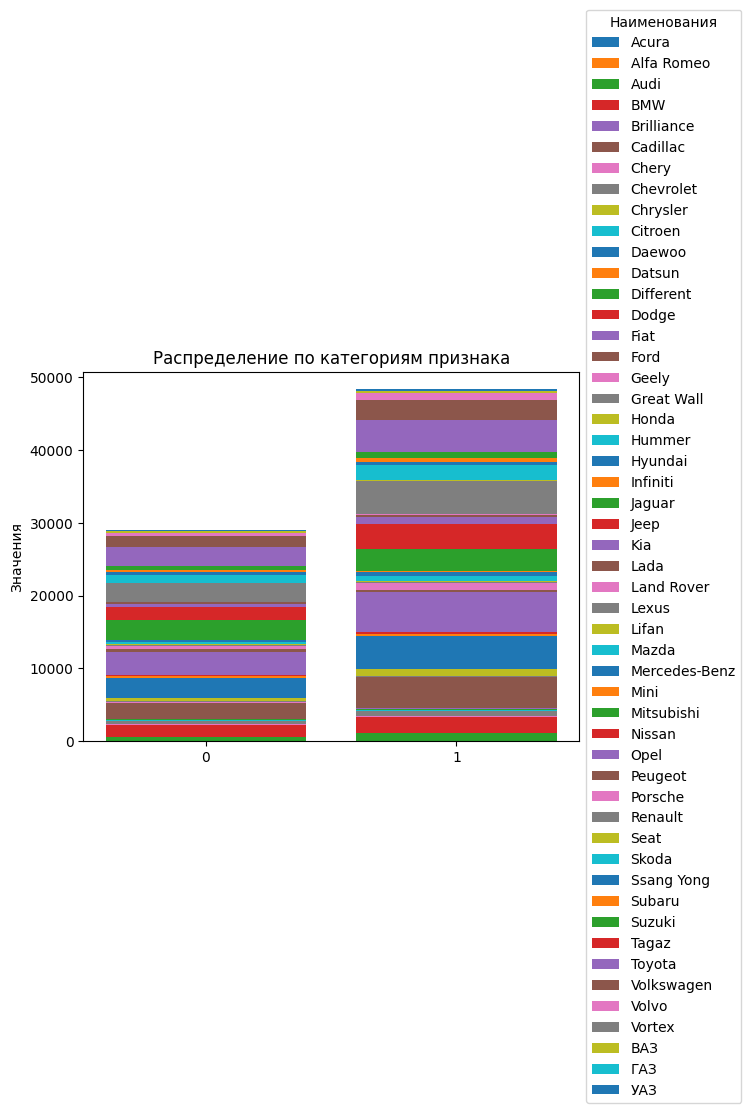

In [30]:
categories = np.array(['0', '1'])
subcategories = df_serv0[feature].tolist()
values = np.array([df_serv0['count'].tolist(), df_serv1['count'].tolist()])
fig, ax = plt.subplots()

bottom_values = np.zeros(len(categories))

for i, subcategory in enumerate(subcategories):
    ax.bar(categories, values[:, i], bottom=bottom_values, label=subcategory)
    bottom_values += values[:, i]

ax.set_ylabel('Значения')
ax.set_title('Распределение по категориям признака')
ax.legend(title='Наименования', loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

Визуально различий в распределении по категориям исседуемого признака в обоих датасетах не наблюдаем, объекты распределены примерно одинаково. Предполагаем, что исследуемый признак VEHICLE_MAKE не оказывает существенного влияния на целевой признак (продление/отказ от продления полиса страхования POLICY_IS_RENEWED).

Однако, совсем отбрасывать признак из датасета не будем - применим кодирование категорий признака на основе корреляции с целевым признаком.

Создадим в служебном датасете с подсчетом уникальных значений по исследуемому признаку дополнительный столбец rank, который будет определяться как количество присуствий этого значения в субдатасете с целевым значением POLICY_IS_RENEWED = 1, деленное на количество присутствий этого значения в субдатасете POLICY_IS_RENEWED = 0, увеличенное в 1000 раз (чтобы не повторялись). Иными словами, мы будем подсказывать модели, насколько чаще конкретное значение категориальной переменной встречаются в субдатасете с продленным полисом КАСКО по сравнению с субдатасетом с непродленным.

In [31]:
df_serv0['rank']=(1000*df_serv1['count']/df_serv0['count']).round().astype(int)

In [32]:
df_serv0

,VEHICLE_MAKE,count,rank
50,Acura,2,1000
49,Alfa Romeo,3,1667
10,Audi,616,1833
7,BMW,1629,1673
46,Brilliance,4,2250
38,Cadillac,27,1407
34,Chery,65,1169
16,Chevrolet,404,1700
44,Chrysler,11,1455
30,Citroen,98,1459


Перекодируем значения категориальной переменной исходя из полученных значений rank в исходном датасете

In [33]:
with pd.option_context("future.no_silent_downcasting", True):
  df[feature]=df[feature].replace(dict(zip(df_serv0[feature], df_serv0['rank'])))

In [34]:
df[feature]=df[feature].round().astype(int)

In [35]:
count_values = df[feature].value_counts().to_frame()
print(count_values.sort_values(feature).to_string(max_rows=15))

              count
VEHICLE_MAKE       
765              99
828             109
850             189
1000             18
1062             33
1133             41
1169            141
...             ...
1858           1294
1860           1007
1876            899
1895             57
1912           1343
2000              9
2250             10


Видим, что соотношение продленных/не продленных полисов варьирует по отдельным значениям исследуемого признака от 76,5% до 225%

VEHICLE_MODEL

In [36]:
count_values = df['VEHICLE_MODEL'].value_counts()
print(count_values)

VEHICLE_MODEL
RAV4        3367
Sportage    2961
Duster      2908
Focus       2557
ix35        2394
            ... 
Express        1
S6             1
Legend         1
S4             1
Vita           1
Name: count, Length: 525, dtype: int64


VEHICLE_MAKE имеет 525 возможных значения

In [37]:
feature='VEHICLE_MODEL'

Меняем значения исследуемого признака с текущих на Different по всему датасету в случае, когда такое значение встречается реже 0,05% случаев (от всего датасета)

In [38]:
total_count = len(df)

# Находим количество уникальных значений и их частоту
name_counts = df[feature].value_counts()

# Определяем значения, которые составляют менее 0,05% от общего объема датасета
threshold = total_count * 0.0005
names_to_replace = name_counts[name_counts < threshold].index

# Заменяем значения в столбце name на 'Different' для тех, которые попадают под условие
df[feature] = df[feature].replace(names_to_replace, 'Different')

Заменим также неинформативные значения

In [39]:
df[feature] = df[feature].replace('Другая модель (Прицепы к грузовым автомобилям)', 'Different')

In [40]:
count_values = df[feature].value_counts()
print(count_values)

VEHICLE_MODEL
RAV4         3367
Different    3293
Sportage     2961
Duster       2908
Focus        2557
             ... 
Roomster       39
3008           39
A8             39
Rexton         39
2114           39
Name: count, Length: 191, dtype: int64


Повторяем разбиение на субдатасеты по целевому признаку

In [41]:
df0 = df.loc[df['POLICY_IS_RENEWED'] == 0]
df1 = df.loc[df['POLICY_IS_RENEWED'] == 1]

Для того, чтобы сравнивать объекты в обоих датасетах, необходимо унифицировать их содержание. Оставим в датасетах только строки (наименования признака), которые присутствуют в обоих датасетах одновременно. Уникальные наименования (присутствуют только в одном датасете) - объединим и отнесем в категорию other. После этого количество наименований в обоих датасетах должно сравняться.

In [42]:
# Находим общие наименования признаков по двум датасетам
common_features = set(df1[feature]).intersection(set(df0[feature]))

# Фильтруем df1 и df0 по общим наименованиям признаков
df1_common = df1[df1[feature].isin(common_features)]
df0_common = df0[df0[feature].isin(common_features)]

# Убираем строки с уникальными наименованиями признаков и суммируем их
other_df1 = df1[~df1[feature].isin(common_features)].groupby(feature, as_index=False).sum()
other_df0 = df0[~df0[feature].isin(common_features)].groupby(feature, as_index=False).sum()

# Объединяем уникальные строки в 'other'
other_df1[feature] = 'other'
other_df0[feature] = 'other'

# Объединяем df1 и df2 с общими признаками
result1 = pd.concat([df1_common, other_df1]).reset_index(drop=True)
result0 = pd.concat([df0_common, other_df0]).reset_index(drop=True)

Сортируем по именам в категории, в алфавитном порядке

In [43]:
df_serv0 = result0[feature].value_counts().reset_index(name='count').sort_values(feature)
df_serv1 = result1[feature].value_counts().reset_index(name='count').sort_values(feature)

In [44]:
df_serv0.shape

(191, 2)

In [45]:
df_serv1.shape

(191, 2)

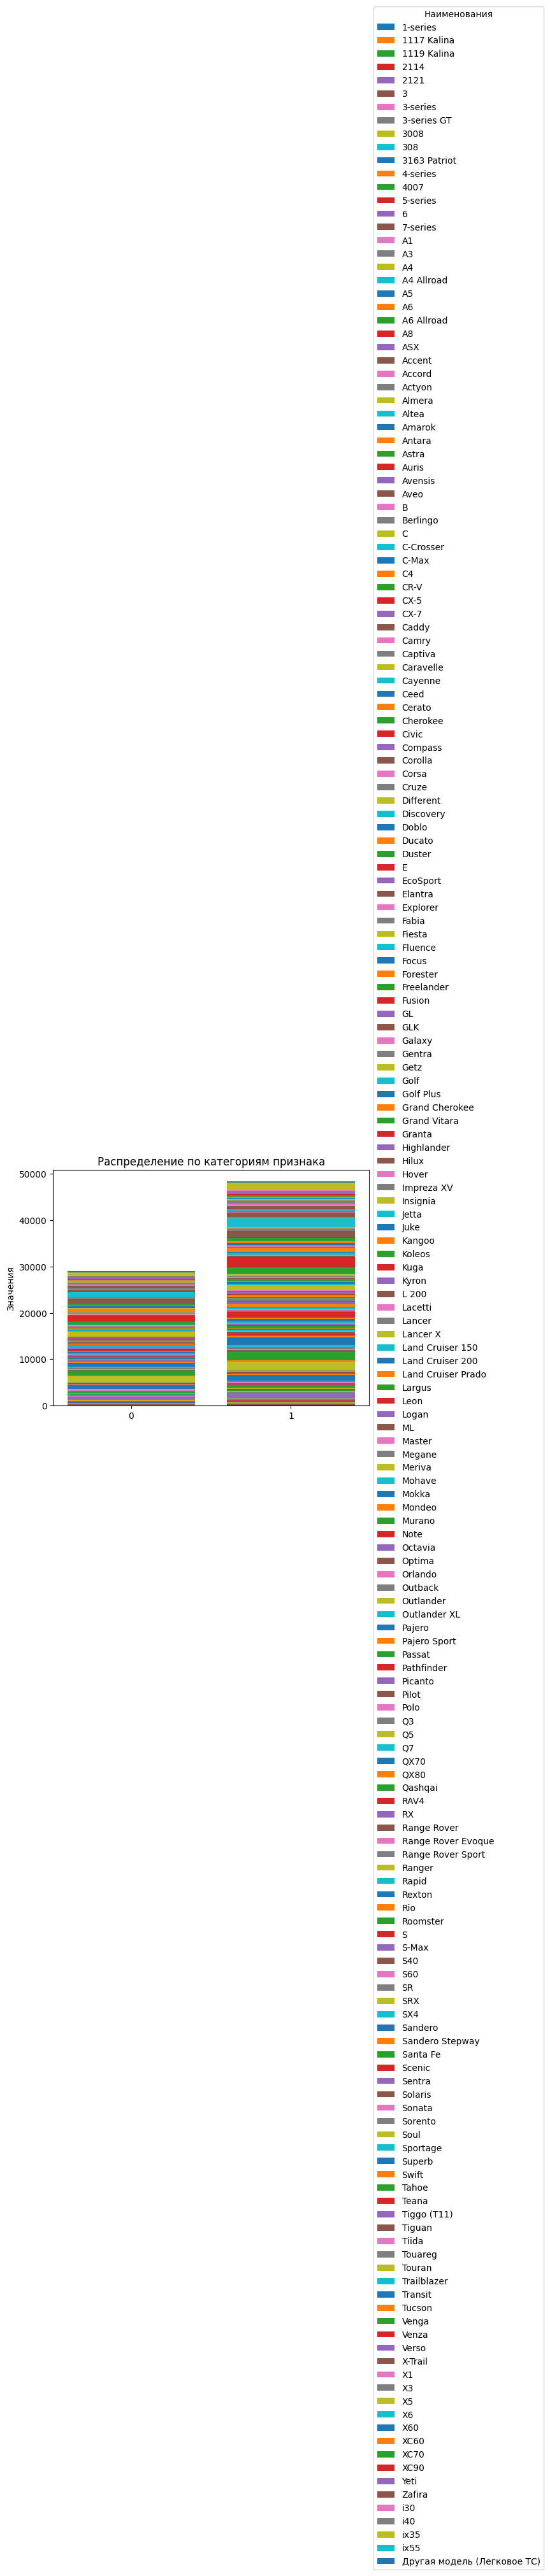

In [46]:
categories = np.array(['0', '1'])
subcategories = df_serv0[feature].tolist()
values = np.array([df_serv0['count'].tolist(), df_serv1['count'].tolist()])
fig, ax = plt.subplots()

bottom_values = np.zeros(len(categories))

for i, subcategory in enumerate(subcategories):
    ax.bar(categories, values[:, i], bottom=bottom_values, label=subcategory)
    bottom_values += values[:, i]

ax.set_ylabel('Значения')
ax.set_title('Распределение по категориям признака')
ax.legend(title='Наименования', loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

Визуально различий в распределении по категориям исседуемого признака в обоих датасетах не наблюдаем, объекты распределены примерно одинаково. Предполагаем, что исследуемый признак VEHICLE_MODEL не оказывает существенного влияния на целевой признак (продление/отказ от продления полиса страхования POLICY_IS_RENEWED).

Однако, совсем отбрасывать признак из датасета не будем - применим кодирование категорий признака на основе корреляции с целевым признаком.

Создадим в служебном датасете с подсчетом уникальных значений по исследуемому признаку дополнительный столбец rank, который будет определяться как количество присуствий этого значения в субдатасете с целевым значением POLICY_IS_RENEWED = 1, деленное на количество присутствий этого значения в субдатасете POLICY_IS_RENEWED = 0, увеличенное в 1000 раз (чтобы не повторялись). Иными словами, мы будем подсказывать модели, насколько чаще конкретное значение категориальной переменной встречаются в субдатасете с продленным полисом КАСКО по сравнению с субдатасетом с непродленным.

In [47]:
df_serv0['rank']=(1000*df_serv1['count']/df_serv0['count']).round().astype(int)

Перекодируем значения категориальной переменной исходя из полученных значений rank в исходном датасете

In [48]:
with pd.option_context("future.no_silent_downcasting", True):
  df[feature]=df[feature].replace(dict(zip(df_serv0[feature], df_serv0['rank'])))

In [49]:
df[feature]=df[feature].round().astype(int)

In [50]:
count_values = df[feature].value_counts().to_frame()
print(count_values.sort_values(feature).to_string(max_rows=15))

               count
VEHICLE_MODEL       
1464              85
1481              82
1498             959
1500             448
1507             691
1520             167
1524            6660
...              ...
1858             283
1871             184
1899            1671
1901             546
1941             579
2000              39
2013            1630


Видим, что соотношение продленных/не продленных полисов варьирует по отдельным значениям исследуемого признака от 146% до 201%, однако количество объектов со сзначением 146% очень мало

POLICY_INTERMEDIARY

In [51]:
count_values = df['POLICY_INTERMEDIARY'].value_counts()
print(count_values)

POLICY_INTERMEDIARY
N       16448
1096     9026
910      2955
1252     1840
326      1084
        ...  
841         1
247         1
151         1
1377        1
930         1
Name: count, Length: 1333, dtype: int64


POLICY_INTERMEDIARY имеет 1406 возможных значений

In [52]:
feature='POLICY_INTERMEDIARY'

Меняем значения исследуемого признака с текущих на Different по всему датасету в случае, когда такое значение встречается реже 0,05% случаев (от всего датасета)

In [53]:
total_count = len(df)

# Находим количество уникальных значений и их частоту
name_counts = df[feature].value_counts()

# Определяем значения, которые составляют менее 0,05% от общего объема датасета
threshold = total_count * 0.0005
names_to_replace = name_counts[name_counts < threshold].index

# Заменяем значения в столбце name на 'Different' для тех, которые попадают под условие
df[feature] = df[feature].replace(names_to_replace, 'Different')

In [54]:
count_values = df[feature].value_counts()
print(count_values)

POLICY_INTERMEDIARY
N            16448
1096          9026
Different     7093
910           2955
1252          1840
             ...  
710             39
319             39
881             39
500             39
202             39
Name: count, Length: 209, dtype: int64


In [55]:
df0 = df.loc[df['POLICY_IS_RENEWED'] == 0]
df1 = df.loc[df['POLICY_IS_RENEWED'] == 1]
common_features = set(df1[feature]).intersection(set(df0[feature]))
df1_common = df1[df1[feature].isin(common_features)]
df0_common = df0[df0[feature].isin(common_features)]
other_df1 = df1[~df1[feature].isin(common_features)].groupby(feature, as_index=False).sum()
other_df0 = df0[~df0[feature].isin(common_features)].groupby(feature, as_index=False).sum()
other_df1[feature] = 'other'
other_df0[feature] = 'other'
result1 = pd.concat([df1_common, other_df1]).reset_index(drop=True)
result0 = pd.concat([df0_common, other_df0]).reset_index(drop=True)
df_serv0 = result0[feature].value_counts().reset_index(name='count').sort_values(feature)
df_serv1 = result1[feature].value_counts().reset_index(name='count').sort_values(feature)

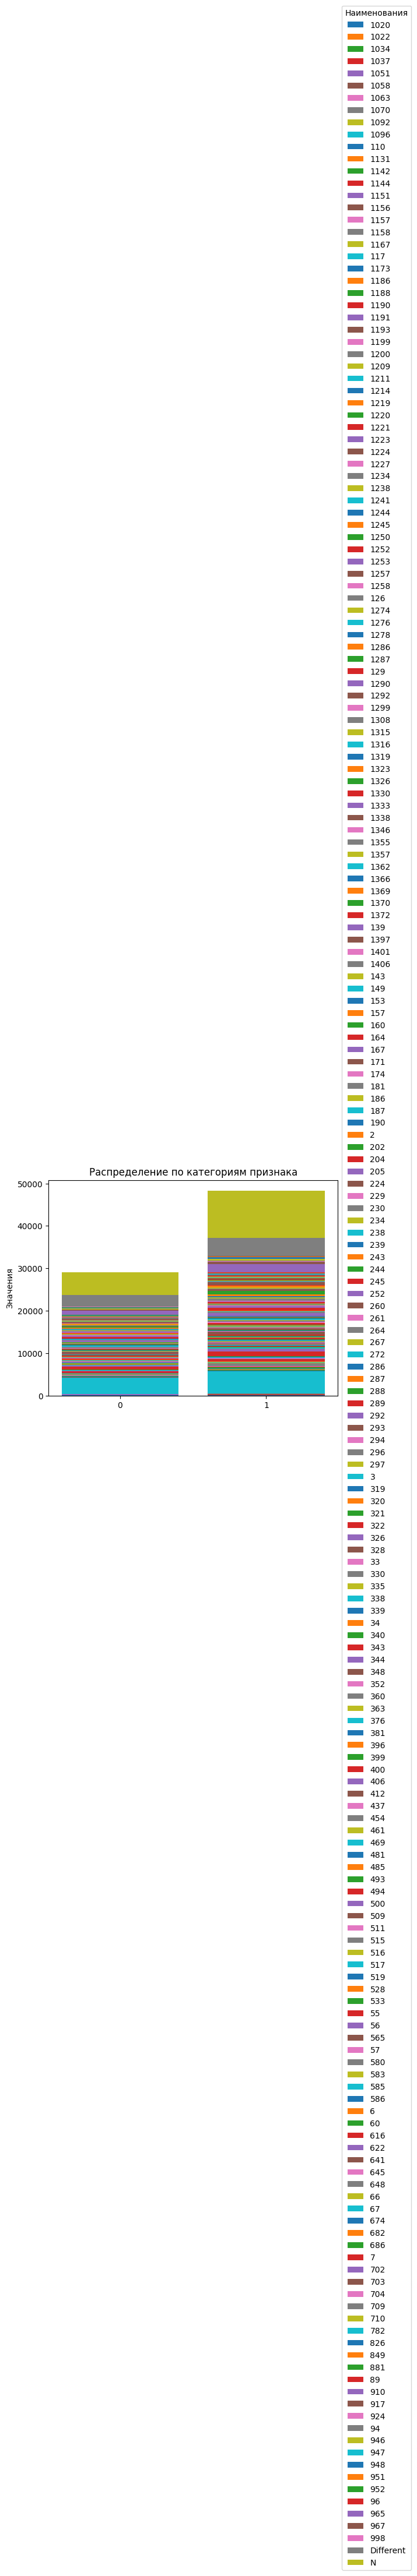

In [56]:
categories = np.array(['0', '1'])
subcategories = df_serv0[feature].tolist()
values = np.array([df_serv0['count'].tolist(), df_serv1['count'].tolist()])
fig, ax = plt.subplots()

bottom_values = np.zeros(len(categories))

for i, subcategory in enumerate(subcategories):
    ax.bar(categories, values[:, i], bottom=bottom_values, label=subcategory)
    bottom_values += values[:, i]

ax.set_ylabel('Значения')
ax.set_title('Распределение по категориям признака')
ax.legend(title='Наименования', loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

Визуально различий в распределении по категориям исседуемого признака в обоих датасетах не наблюдаем, объекты распределены примерно одинаково. Предполагаем, что исследуемый признак POLICY_INTERMEDIARY не оказывает существенного влияния на целевой признак (продление/отказ от продления полиса страхования POLICY_IS_RENEWED).

Однако, совсем отбрасывать признак из датасета не будем - применим кодирование категорий признака на основе корреляции с целевым признаком.

Создадим в служебном датасете с подсчетом уникальных значений по исследуемому признаку дополнительный столбец rank, который будет определяться как количество присуствий этого значения в субдатасете с целевым значением POLICY_IS_RENEWED = 1, деленное на количество присутствий этого значения в субдатасете POLICY_IS_RENEWED = 0, увеличенное в 1000 раз (чтобы не повторялись). Иными словами, мы будем подсказывать модели, насколько чаще конкретное значение категориальной переменной встречаются в субдатасете с продленным полисом КАСКО по сравнению с субдатасетом с непродленным.

In [57]:
df_serv0['rank']=(1000*df_serv1['count']/df_serv0['count']).round().astype(int)

with pd.option_context("future.no_silent_downcasting", True):
  df[feature]=df[feature].replace(dict(zip(df_serv0[feature], df_serv0['rank'])))

df[feature]=df[feature].round().astype(int)
count_values = df[feature].value_counts().to_frame()
print(count_values.sort_values(feature).to_string(max_rows=15))

                     count
POLICY_INTERMEDIARY       
1329                   443
1336                   264
1343                   160
1347                   302
1354                   205
1357                   127
1361                   274
...                    ...
1955                  1054
1968                  1032
1982                  1002
2000                   180
2125                    98
2133                 16448
2400                    39


Видим, что соотношение продленных/не продленных полисов варьирует по отдельным значениям исследуемого признака от 133% до 240%, однако количество объектов со сзначением 240% очень мало. По данным также можно выяснить, какой агент работает лучше остальных (наивысший коэффициент продления полисов)

INSURER_GENDER

In [58]:
count_values = df['INSURER_GENDER'].value_counts()
print(count_values)

INSURER_GENDER
M    48923
F    28484
Name: count, dtype: int64


*Всего 2 значения, можно кодировать по шкале, применяем Label Encoder*

In [59]:
df['INSURER_GENDER'] = l.fit_transform(df['INSURER_GENDER'])

In [60]:
count_values = df['INSURER_GENDER'].value_counts()
print(count_values)

INSURER_GENDER
1    48923
0    28484
Name: count, dtype: int64


POLICY_CLM_N

In [61]:
count_values = df['POLICY_CLM_N'].value_counts()
print(count_values)

POLICY_CLM_N
0      54481
1S      8073
1L      8000
2       4972
3       1377
4+       458
n/d       46
Name: count, dtype: int64


Видим, что мода признака = 0. Заменяем n/d на моду

In [62]:
df['POLICY_CLM_N'] = df['POLICY_CLM_N'].replace('n/d', '0')

In [63]:
count_values = df['POLICY_CLM_N'].value_counts()
print(count_values)

POLICY_CLM_N
0     54527
1S     8073
1L     8000
2      4972
3      1377
4+      458
Name: count, dtype: int64


In [64]:
df['POLICY_CLM_N'] = df['POLICY_CLM_N'].replace('1S', '1a')
df['POLICY_CLM_N'] = df['POLICY_CLM_N'].replace('1L', '1b')

*Всего 6 значений, можно кодировать по шкале, применяем Label Encoder*

In [65]:
df['POLICY_CLM_N'] = l.fit_transform(df['POLICY_CLM_N'])

In [66]:
count_values = df['POLICY_CLM_N'].value_counts()
print(count_values)

POLICY_CLM_N
0    54527
1     8073
2     8000
3     4972
4     1377
5      458
Name: count, dtype: int64


POLICY_CLM_GLT_N

In [67]:
count_values = df['POLICY_CLM_GLT_N'].value_counts()
print(count_values)

POLICY_CLM_GLT_N
0      57885
1S      8016
1L      6223
2       3941
3        961
4+       335
n/d       46
Name: count, dtype: int64


In [68]:
df['POLICY_CLM_GLT_N'] = df['POLICY_CLM_GLT_N'].replace('1S', '1a')
df['POLICY_CLM_GLT_N'] = df['POLICY_CLM_GLT_N'].replace('1L', '1b')

Видим, что мода признака = 0. Заменяем n/d на моду

In [69]:
df['POLICY_CLM_GLT_N'] = df['POLICY_CLM_GLT_N'].replace('n/d', '0')

*Всего 6 значений, можно кодировать по шкале, применяем Label Encoder*

In [70]:
df['POLICY_CLM_GLT_N'] = l.fit_transform(df['POLICY_CLM_GLT_N'])

In [71]:
count_values = df['POLICY_CLM_GLT_N'].value_counts()
print(count_values)

POLICY_CLM_GLT_N
0    57931
1     8016
2     6223
3     3941
4      961
5      335
Name: count, dtype: int64


POLICY_PRV_CLM_N

In [72]:
count_values = df['POLICY_PRV_CLM_N'].value_counts()
print(count_values)

POLICY_PRV_CLM_N
0     35747
N     26680
1S     5817
1L     5403
2      3012
3       641
4+      107
Name: count, dtype: int64


N  - отсутствие значения (нет убытков по предыдущему полису) - меняем на моду 0

In [73]:
df['POLICY_PRV_CLM_N'] = df['POLICY_PRV_CLM_N'].replace('1S', '1a')
df['POLICY_PRV_CLM_N'] = df['POLICY_PRV_CLM_N'].replace('1L', '1b')

In [74]:
df['POLICY_PRV_CLM_N'] = df['POLICY_PRV_CLM_N'].replace('N', '0')

Всего 6 значений, можно кодировать по шкале, применяем Label Encoder*

In [75]:
df['POLICY_PRV_CLM_N'] = l.fit_transform(df['POLICY_PRV_CLM_N'])

In [76]:
count_values = df['POLICY_PRV_CLM_N'].value_counts()
print(count_values)

POLICY_PRV_CLM_N
0    62427
1     5817
2     5403
3     3012
4      641
5      107
Name: count, dtype: int64


POLICY_PRV_CLM_GLT_N

In [77]:
count_values = df['POLICY_PRV_CLM_GLT_N'].value_counts()
print(count_values)

POLICY_PRV_CLM_GLT_N
0     38588
N     26680
1S     5879
1L     3850
2      2073
3       285
4+       52
Name: count, dtype: int64


In [78]:
df['POLICY_PRV_CLM_GLT_N'] = df['POLICY_PRV_CLM_GLT_N'].replace('1S', '1a')
df['POLICY_PRV_CLM_GLT_N'] = df['POLICY_PRV_CLM_GLT_N'].replace('1L', '1b')

N  - отсутствие значения (нет убытков по предыдущему полису) - меняем на моду 0

In [79]:
df['POLICY_PRV_CLM_GLT_N'] = df['POLICY_PRV_CLM_GLT_N'].replace('N', '0')

In [80]:
df['POLICY_PRV_CLM_GLT_N'] = l.fit_transform(df['POLICY_PRV_CLM_GLT_N'])

In [81]:
count_values = df['POLICY_PRV_CLM_GLT_N'].value_counts()
print(count_values)

POLICY_PRV_CLM_GLT_N
0    65268
1     5879
2     3850
3     2073
4      285
5       52
Name: count, dtype: int64


*Всего 7 значений, можно кодировать по шкале, применяем Label Encoder*

POLICY_YEARS_RENEWED_N

In [82]:
count_values = df['POLICY_YEARS_RENEWED_N'].value_counts()
print(count_values)

POLICY_YEARS_RENEWED_N
0     26634
1     20261
2     12230
3      9261
4      4943
5      1806
6      1393
7       667
8        90
9        62
N        46
10       14
Name: count, dtype: int64


Видим, что мода признака = 0. Заменяем N на моду

In [83]:
df['POLICY_YEARS_RENEWED_N'] = df['POLICY_YEARS_RENEWED_N'].replace('N', '0')

In [84]:
count_values = df['POLICY_YEARS_RENEWED_N'].value_counts()
print(count_values)

POLICY_YEARS_RENEWED_N
0     26680
1     20261
2     12230
3      9261
4      4943
5      1806
6      1393
7       667
8        90
9        62
10       14
Name: count, dtype: int64


In [85]:
df['POLICY_YEARS_RENEWED_N'] = df['POLICY_YEARS_RENEWED_N'].replace('10', '99')

*Всего 11 значений, можно кодировать по шкале, применяем Label Encoder*

In [86]:
df['POLICY_YEARS_RENEWED_N'] = l.fit_transform(df['POLICY_YEARS_RENEWED_N'])

In [87]:
count_values = df['POLICY_YEARS_RENEWED_N'].value_counts()
print(count_values)

POLICY_YEARS_RENEWED_N
0     26680
1     20261
2     12230
3      9261
4      4943
5      1806
6      1393
7       667
8        90
9        62
10       14
Name: count, dtype: int64


CLIENT_REGISTRATION_REGION

In [88]:
count_values = df['CLIENT_REGISTRATION_REGION'].value_counts()
print(count_values)

CLIENT_REGISTRATION_REGION
Санкт-Петербург             31124
Москва                      27621
Московская                  10306
Ленинградская                4660
N                             898
                            ...  
Забайкальский                   2
Северная Осетия - Алания        2
Тюменская                       2
Чукотский                       1
Камчатский                      1
Name: count, Length: 83, dtype: int64


In [89]:
feature='CLIENT_REGISTRATION_REGION'

Меняем значения исследуемого признака с текущих на Different по всему датасету в случае, когда такое значение встречается реже 0,05% случаев (от всего датасета)

In [90]:
total_count = len(df)

# Находим количество уникальных значений и их частоту
name_counts = df[feature].value_counts()

# Определяем значения, которые составляют менее 0,05% от общего объема датасета
threshold = total_count * 0.0005
names_to_replace = name_counts[name_counts < threshold].index

# Заменяем значения в столбце name на 'Different' для тех, которые попадают под условие
df[feature] = df[feature].replace(names_to_replace, 'Different')

In [91]:
df[feature] = df[feature].replace('N', 'Different')

In [92]:
count_values = df[feature].value_counts()
print(count_values)

CLIENT_REGISTRATION_REGION
Санкт-Петербург    31124
Москва             27621
Московская         10306
Ленинградская       4660
Different           1821
Калужская            212
Тульская             179
Тверская             158
Владимирская         134
Смоленская           110
Новгородская         105
Псковская             95
Нижегородская         83
Саратовская           81
Самарская             75
Рязанская             74
Мурманская            72
Ивановская            70
Волгоградская         64
Брянская              63
Карелия               62
Тамбовская            60
Ростовская            47
Мордовия              46
Белгородская          45
Свердловская          40
Name: count, dtype: int64


In [93]:
df0 = df.loc[df['POLICY_IS_RENEWED'] == 0]
df1 = df.loc[df['POLICY_IS_RENEWED'] == 1]
common_features = set(df1[feature]).intersection(set(df0[feature]))
df1_common = df1[df1[feature].isin(common_features)]
df0_common = df0[df0[feature].isin(common_features)]
other_df1 = df1[~df1[feature].isin(common_features)].groupby(feature, as_index=False).sum()
other_df0 = df0[~df0[feature].isin(common_features)].groupby(feature, as_index=False).sum()
other_df1[feature] = 'other'
other_df0[feature] = 'other'
result1 = pd.concat([df1_common, other_df1]).reset_index(drop=True)
result0 = pd.concat([df0_common, other_df0]).reset_index(drop=True)
df_serv0 = result0[feature].value_counts().reset_index(name='count').sort_values(feature)
df_serv1 = result1[feature].value_counts().reset_index(name='count').sort_values(feature)

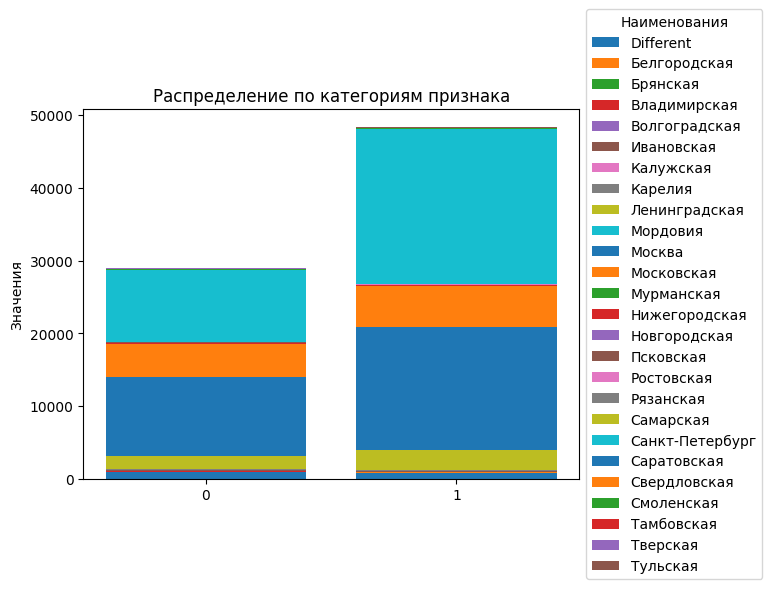

In [94]:
categories = np.array(['0', '1'])
subcategories = df_serv0[feature].tolist()
values = np.array([df_serv0['count'].tolist(), df_serv1['count'].tolist()])
fig, ax = plt.subplots()

bottom_values = np.zeros(len(categories))

for i, subcategory in enumerate(subcategories):
    ax.bar(categories, values[:, i], bottom=bottom_values, label=subcategory)
    bottom_values += values[:, i]

ax.set_ylabel('Значения')
ax.set_title('Распределение по категориям признака')
ax.legend(title='Наименования', loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

Визуально есть некоторые различия в распределении по категориям исседуемого признака в обоих датасетах.

Применим кодирование категорий признака на основе корреляции с целевым признаком.

Создадим в служебном датасете с подсчетом уникальных значений по исследуемому признаку дополнительный столбец rank, который будет определяться как количество присуствий этого значения в субдатасете с целевым значением POLICY_IS_RENEWED = 1, деленное на количество присутствий этого значения в субдатасете POLICY_IS_RENEWED = 0, увеличенное в 1000 раз (чтобы не повторялись). Иными словами, мы будем подсказывать модели, насколько чаще конкретное значение категориальной переменной встречаются в субдатасете с продленным полисом КАСКО по сравнению с субдатасетом с непродленным.

In [95]:
df_serv0['rank']=(1000*df_serv1['count']/df_serv0['count']).round().astype(int)

with pd.option_context("future.no_silent_downcasting", True):
  df[feature]=df[feature].replace(dict(zip(df_serv0[feature], df_serv0['rank'])))

df[feature]=df[feature].round().astype(int)
count_values = df[feature].value_counts().to_frame()
print(count_values.sort_values(feature).to_string(max_rows=15))

                            count
CLIENT_REGISTRATION_REGION       
662                           158
833                           110
871                           212
895                            40
907                           105
909                          1821
914                            63
...                           ...
1050                           47
1051                           70
1214                          179
1233                        10306
1535                         4660
1705                        31124
1968                        27621


Видим, что соотношение продленных/не продленных полисов варьирует по отдельным значениям исследуемого признака от 66% до 197%.

------------------------

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 77407 entries, 0 to 96604
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   POLICY_ID                      77407 non-null  int64  
 1   POLICY_BEGIN_MONTH             77407 non-null  int64  
 2   POLICY_END_MONTH               77407 non-null  int64  
 3   POLICY_IS_RENEWED              77407 non-null  int64  
 4   POLICY_SALES_CHANNEL           77407 non-null  int64  
 5   POLICY_SALES_CHANNEL_GROUP     77407 non-null  int64  
 6   POLICY_BRANCH                  77407 non-null  int64  
 7   POLICY_MIN_AGE                 77407 non-null  int64  
 8   POLICY_MIN_DRIVING_EXPERIENCE  77407 non-null  int64  
 9   VEHICLE_MAKE                   77407 non-null  int64  
 10  VEHICLE_MODEL                  77407 non-null  int64  
 11  VEHICLE_ENGINE_POWER           77407 non-null  float64
 12  VEHICLE_IN_CREDIT              77407 non-null  int6

In [97]:
df.head(10)

,POLICY_ID,POLICY_BEGIN_MONTH,POLICY_END_MONTH,POLICY_IS_RENEWED,POLICY_SALES_CHANNEL,POLICY_SALES_CHANNEL_GROUP,POLICY_BRANCH,POLICY_MIN_AGE,POLICY_MIN_DRIVING_EXPERIENCE,VEHICLE_MAKE,...,POLICY_PRV_CLM_GLT_N,CLIENT_HAS_DAGO,CLIENT_HAS_OSAGO,POLICY_COURT_SIGN,CLAIM_AVG_ACC_ST_PRD,POLICY_HAS_COMPLAINTS,POLICY_YEARS_RENEWED_N,POLICY_DEDUCT_VALUE,CLIENT_REGISTRATION_REGION,POLICY_PRICE_CHANGE
0,1,1,1,1,39,1,0,51,12,1912,...,0,1,0,0,0.0,0,0,0.0,1214,-1.00
1,2,1,1,1,50,5,0,35,7,1813,...,0,1,1,0,0.0,0,4,0.0,1968,-0.05
2,3,1,1,1,52,6,0,41,6,1694,...,2,0,0,0,0.0,0,1,12518.0,1233,-0.07
3,4,1,1,1,50,5,0,36,12,1459,...,0,1,1,0,0.0,0,6,15000.0,1968,0.05
4,5,1,1,0,52,6,1,42,5,1706,...,0,0,0,0,0.0,0,0,50000.0,1535,0.17
5,6,2,1,1,2,4,1,60,40,1858,...,0,0,0,0,0.0,0,3,7500.0,1705,-0.02
6,7,1,1,1,52,6,0,41,6,1694,...,0,0,0,0,0.0,0,0,0.0,1968,-0.23
7,8,2,2,1,10,1,1,48,19,1663,...,0,1,1,0,0.0,0,3,0.0,1705,0.04
8,9,1,1,0,53,6,0,27,7,1673,...,0,0,0,0,4.0,0,0,0.0,1968,-1.00
10,11,1,1,0,50,5,1,38,18,1694,...,0,0,1,0,0.0,0,0,20000.0,909,-0.06


In [98]:
df = df.drop('POLICY_ID', axis=1) #удаляем незначащий столбец ID

In [99]:
df.describe().T.style.background_gradient(cmap='YlOrRd')

,count,mean,std,min,25%,50%,75%,max
POLICY_BEGIN_MONTH,77407.000000,6.888033,3.396889,1.000000,4.000000,7.000000,10.000000,12.000000
POLICY_END_MONTH,77407.000000,6.866046,3.400070,1.000000,4.000000,7.000000,10.000000,12.000000
POLICY_IS_RENEWED,77407.000000,0.624956,0.484137,0.000000,0.000000,1.000000,1.000000,1.000000
POLICY_SALES_CHANNEL,77407.000000,47.354064,14.036828,1.000000,50.000000,52.000000,53.000000,63.000000
POLICY_SALES_CHANNEL_GROUP,77407.000000,5.123916,1.585383,1.000000,5.000000,6.000000,6.000000,8.000000
POLICY_BRANCH,77407.000000,0.474531,0.499354,0.000000,0.000000,0.000000,1.000000,1.000000
POLICY_MIN_AGE,77407.000000,42.627359,10.715267,18.000000,34.000000,41.000000,50.000000,86.000000
POLICY_MIN_DRIVING_EXPERIENCE,77407.000000,35.122017,200.828668,0.000000,8.000000,14.000000,19.000000,2015.000000
VEHICLE_MAKE,77407.000000,1669.598938,141.778605,765.000000,1663.000000,1680.000000,1733.000000,2250.000000
VEHICLE_MODEL,77407.000000,1669.796853,111.967299,1464.000000,1579.000000,1670.000000,1716.000000,2013.000000


In [100]:
df.duplicated().sum()

4

Дубликаты появились, но до удаления столбца POLICE_ID их не было, это просто объекты с одинаковыми значениями по всем признакам

<Axes: >

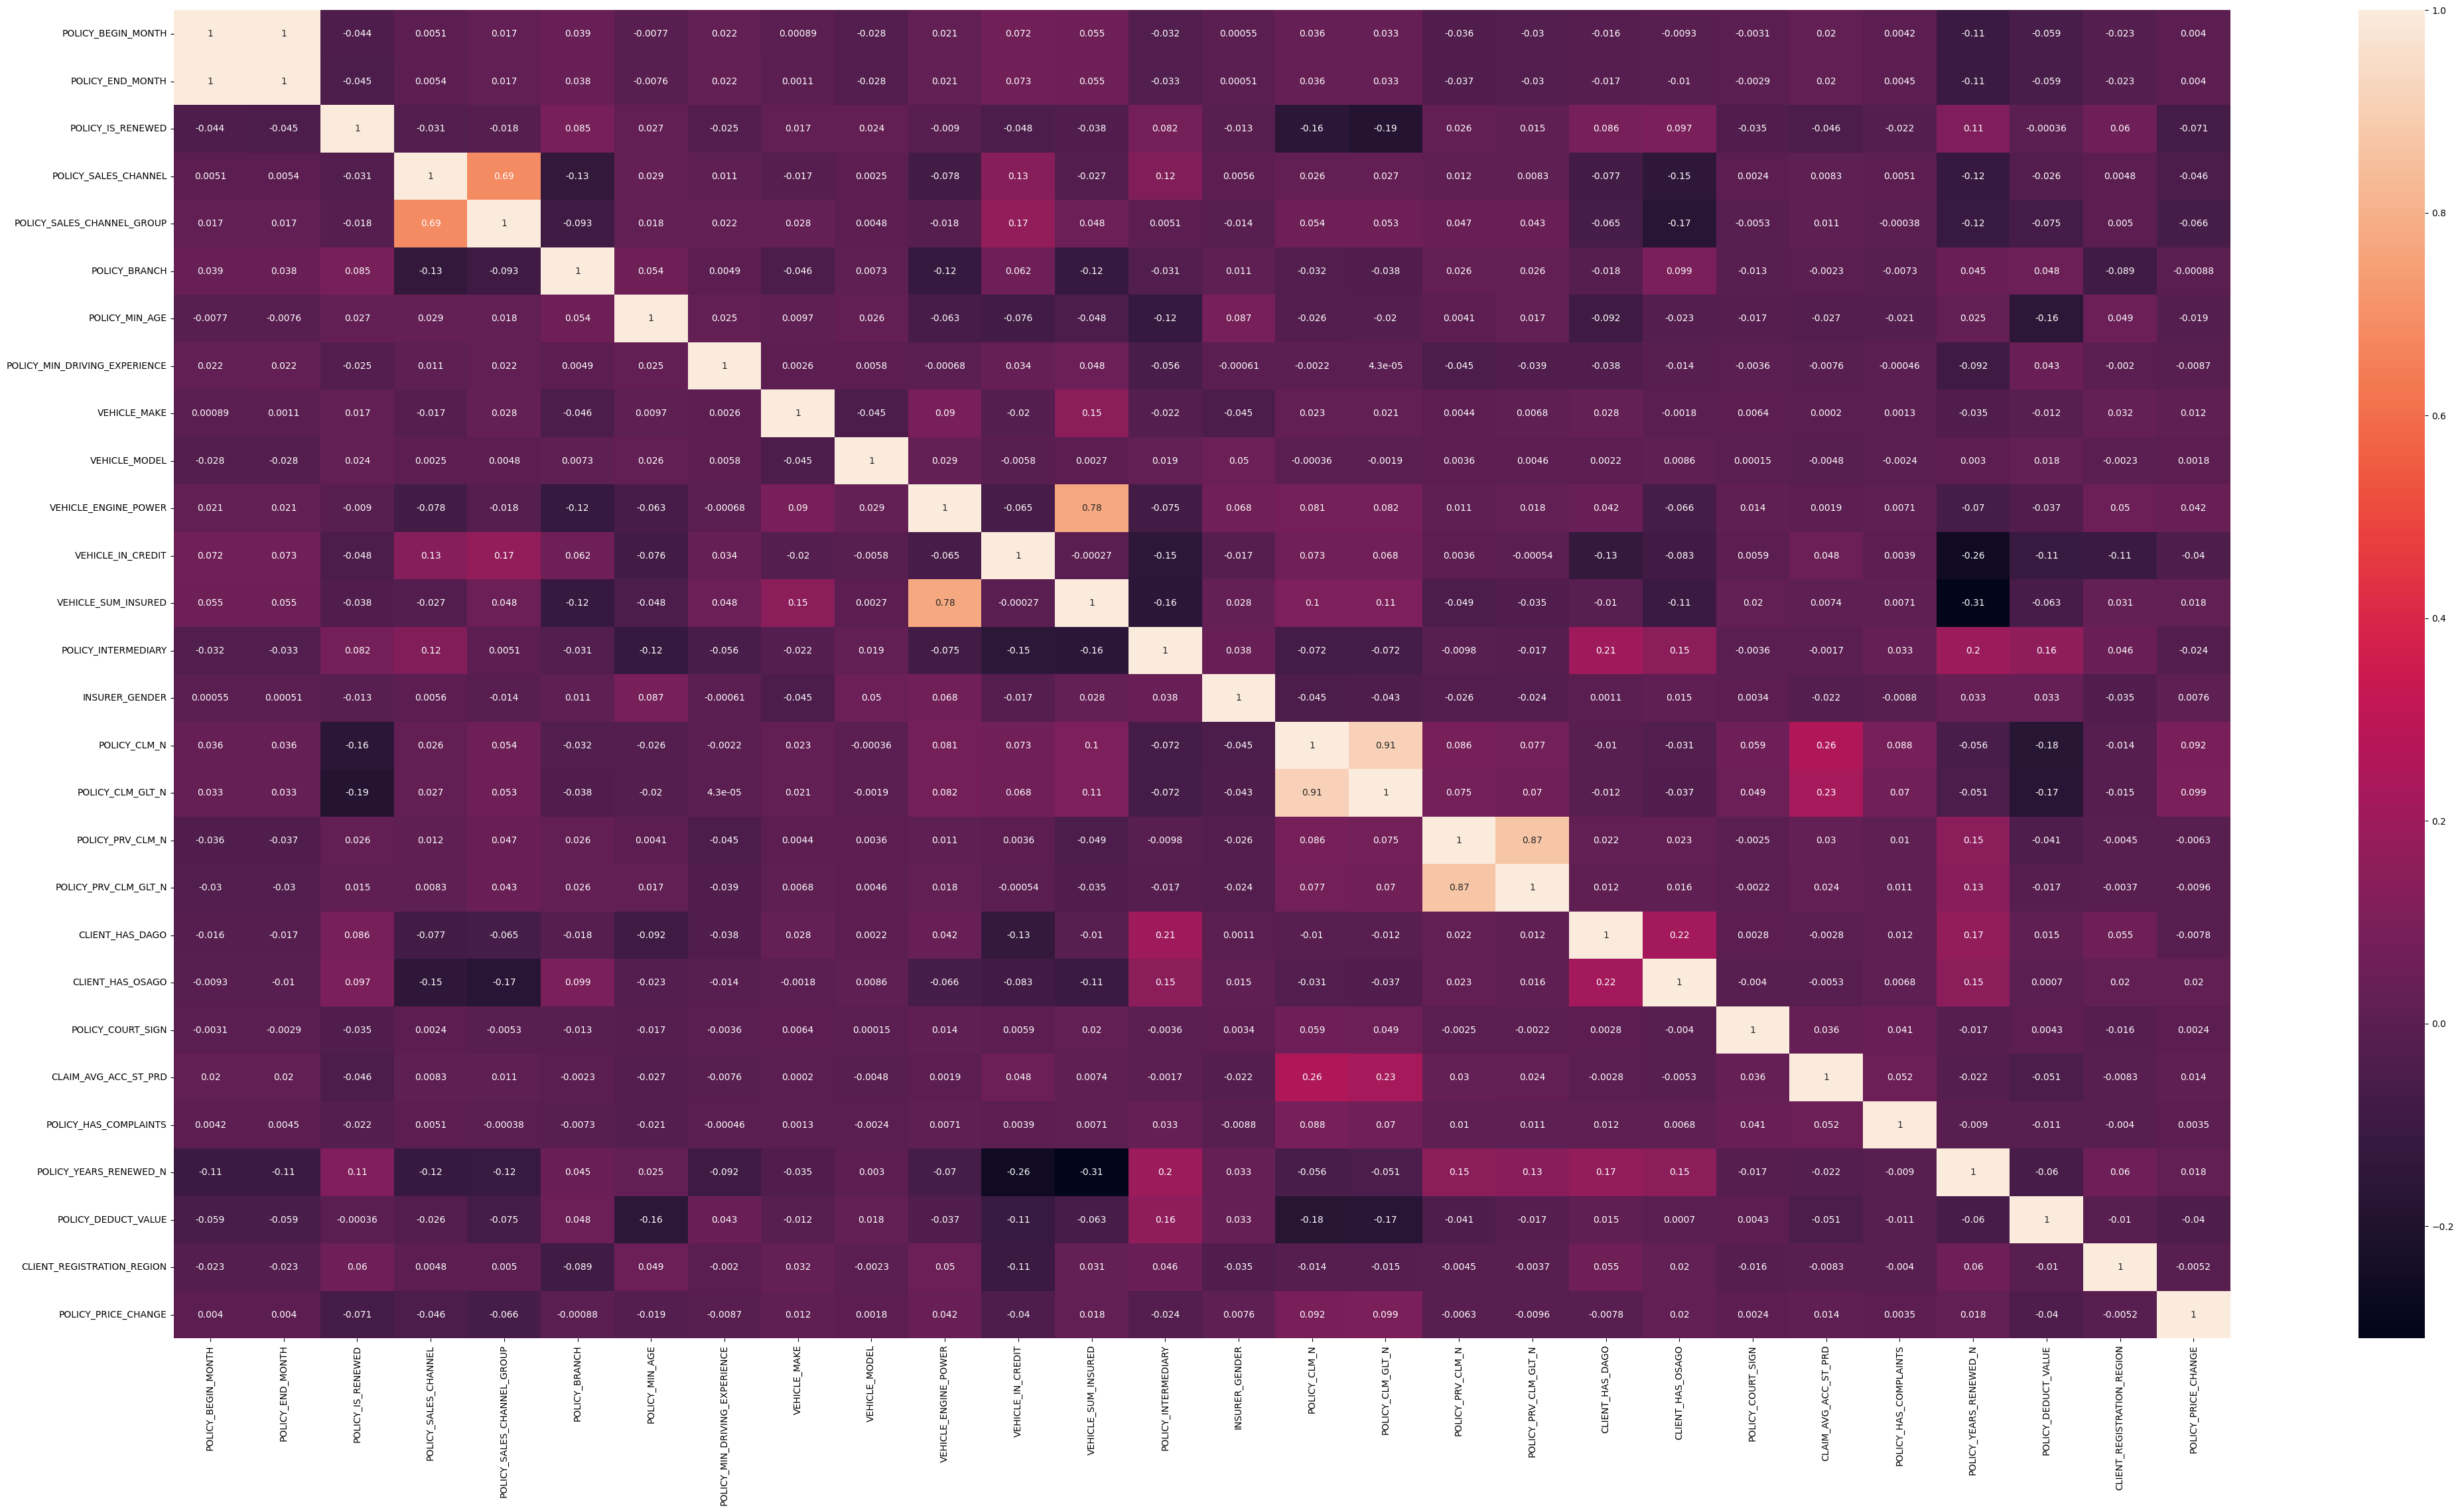

In [101]:
correlation_matrix = df.corr()
plt.figure(figsize= (50, 26))
sns.heatmap(correlation_matrix, annot = True)

**Визуализируем распределения признаков**

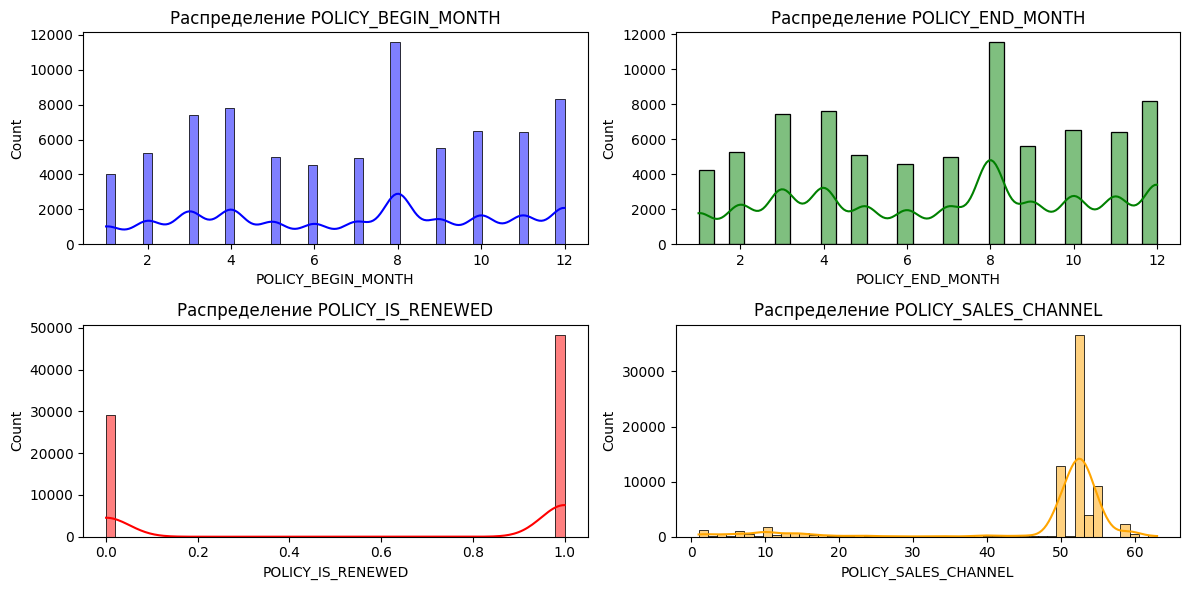

In [102]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
sns.histplot(df['POLICY_BEGIN_MONTH'], bins=50, kde=True, color='blue')
plt.title('Распределение POLICY_BEGIN_MONTH')

plt.subplot(2, 2, 2)
sns.histplot(df['POLICY_END_MONTH'], bins=30, kde=True, color='green')
plt.title('Распределение POLICY_END_MONTH')

plt.subplot(2, 2, 3)
sns.histplot(df['POLICY_IS_RENEWED'], bins=50, kde=True, color='red')
plt.title('Распределение POLICY_IS_RENEWED')

plt.subplot(2, 2, 4)
sns.histplot(df['POLICY_SALES_CHANNEL'], bins=50, kde=True, color='orange')
plt.title('Распределение POLICY_SALES_CHANNEL')


plt.tight_layout()
plt.show()

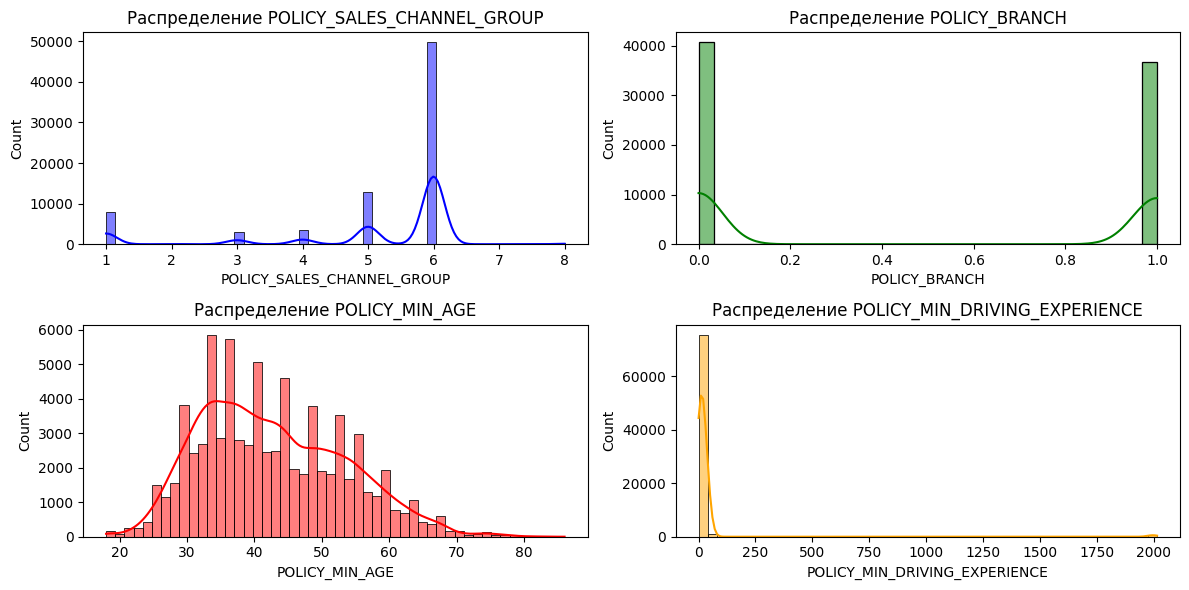

In [103]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
sns.histplot(df['POLICY_SALES_CHANNEL_GROUP'], bins=50, kde=True, color='blue')
plt.title('Распределение POLICY_SALES_CHANNEL_GROUP')

plt.subplot(2, 2, 2)
sns.histplot(df['POLICY_BRANCH'], bins=30, kde=True, color='green')
plt.title('Распределение POLICY_BRANCH')

plt.subplot(2, 2, 3)
sns.histplot(df['POLICY_MIN_AGE'], bins=50, kde=True, color='red')
plt.title('Распределение POLICY_MIN_AGE')

plt.subplot(2, 2, 4)
sns.histplot(df['POLICY_MIN_DRIVING_EXPERIENCE'], bins=50, kde=True, color='orange')
plt.title('Распределение POLICY_MIN_DRIVING_EXPERIENCE')


plt.tight_layout()
plt.show()

Подозреваем наличие выбросов у признака POLICY_MIN_DRIVING_EXPERIENCE - на правой границе диапазона рост частоты объектов

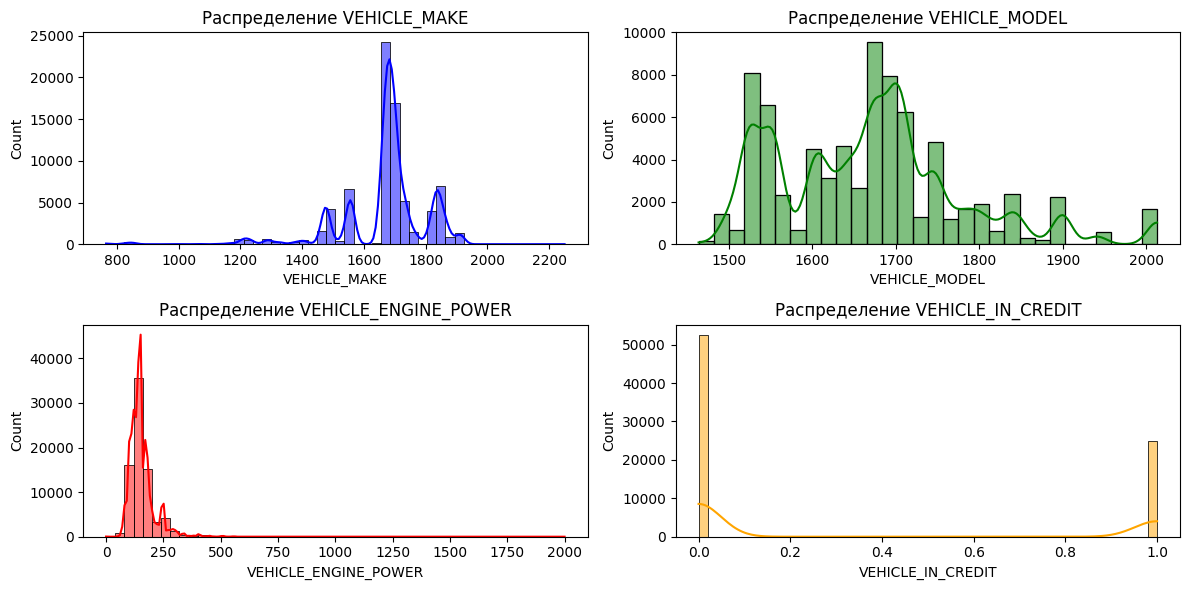

In [104]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
sns.histplot(df['VEHICLE_MAKE'], bins=50, kde=True, color='blue')
plt.title('Распределение VEHICLE_MAKE')

plt.subplot(2, 2, 2)
sns.histplot(df['VEHICLE_MODEL'], bins=30, kde=True, color='green')
plt.title('Распределение VEHICLE_MODEL')

plt.subplot(2, 2, 3)
sns.histplot(df['VEHICLE_ENGINE_POWER'], bins=50, kde=True, color='red')
plt.title('Распределение VEHICLE_ENGINE_POWER')

plt.subplot(2, 2, 4)
sns.histplot(df['VEHICLE_IN_CREDIT'], bins=50, kde=True, color='orange')
plt.title('Распределение VEHICLE_IN_CREDIT')


plt.tight_layout()
plt.show()

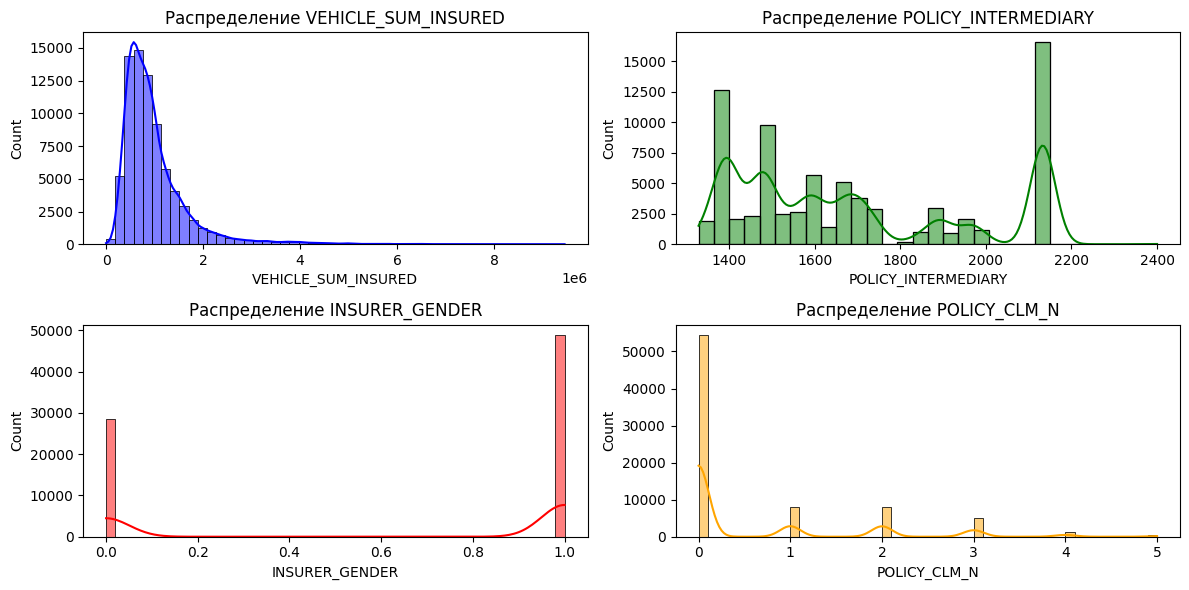

In [105]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
sns.histplot(df['VEHICLE_SUM_INSURED'], bins=50, kde=True, color='blue')
plt.title('Распределение VEHICLE_SUM_INSURED')

plt.subplot(2, 2, 2)
sns.histplot(df['POLICY_INTERMEDIARY'], bins=30, kde=True, color='green')
plt.title('Распределение POLICY_INTERMEDIARY')

plt.subplot(2, 2, 3)
sns.histplot(df['INSURER_GENDER'], bins=50, kde=True, color='red')
plt.title('Распределение INSURER_GENDER')

plt.subplot(2, 2, 4)
sns.histplot(df['POLICY_CLM_N'], bins=50, kde=True, color='orange')
plt.title('Распределение POLICY_CLM_N')


plt.tight_layout()
plt.show()

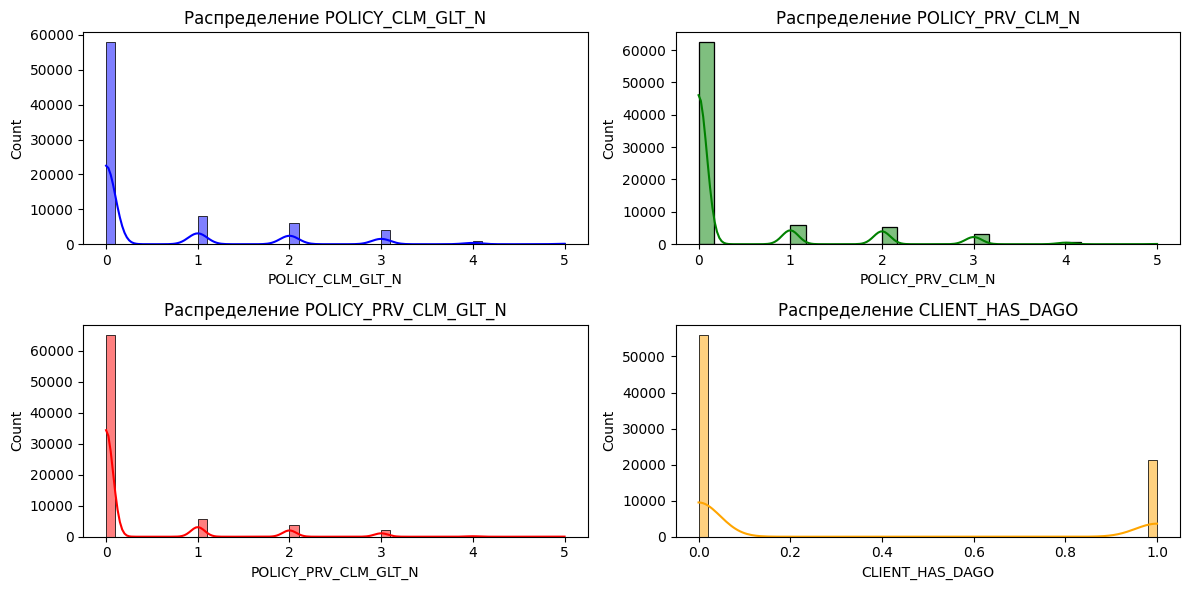

In [106]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
sns.histplot(df['POLICY_CLM_GLT_N'], bins=50, kde=True, color='blue')
plt.title('Распределение POLICY_CLM_GLT_N')

plt.subplot(2, 2, 2)
sns.histplot(df['POLICY_PRV_CLM_N'], bins=30, kde=True, color='green')
plt.title('Распределение POLICY_PRV_CLM_N')

plt.subplot(2, 2, 3)
sns.histplot(df['POLICY_PRV_CLM_GLT_N'], bins=50, kde=True, color='red')
plt.title('Распределение POLICY_PRV_CLM_GLT_N')

plt.subplot(2, 2, 4)
sns.histplot(df['CLIENT_HAS_DAGO'], bins=50, kde=True, color='orange')
plt.title('Распределение CLIENT_HAS_DAGO')


plt.tight_layout()
plt.show()

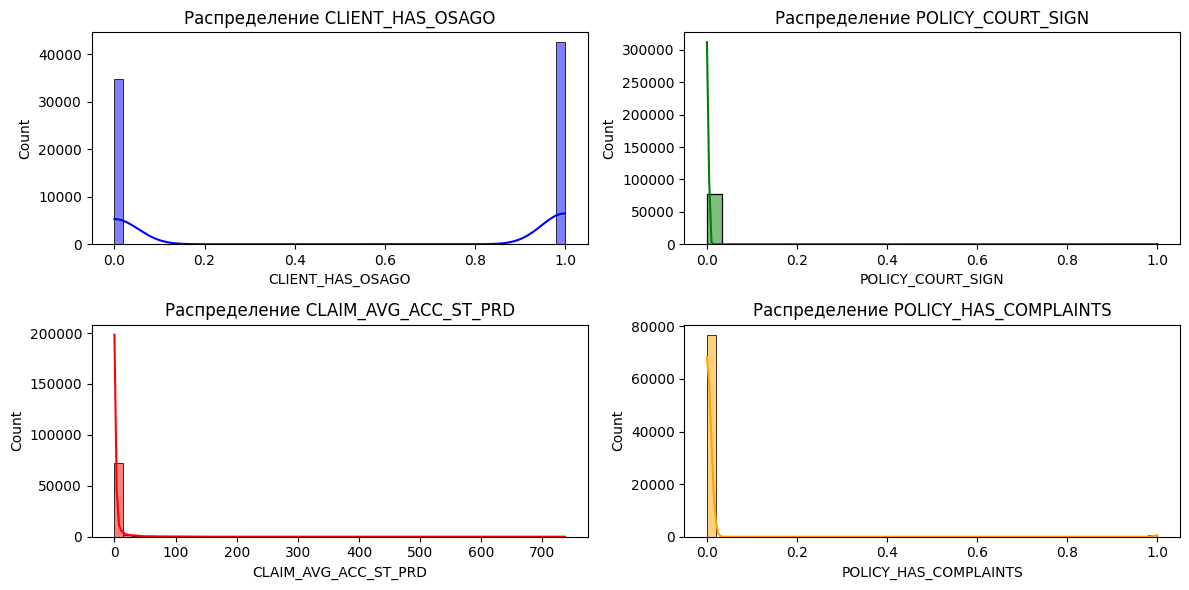

In [107]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
sns.histplot(df['CLIENT_HAS_OSAGO'], bins=50, kde=True, color='blue')
plt.title('Распределение CLIENT_HAS_OSAGO')

plt.subplot(2, 2, 2)
sns.histplot(df['POLICY_COURT_SIGN'], bins=30, kde=True, color='green')
plt.title('Распределение POLICY_COURT_SIGN')

plt.subplot(2, 2, 3)
sns.histplot(df['CLAIM_AVG_ACC_ST_PRD'], bins=50, kde=True, color='red')
plt.title('Распределение CLAIM_AVG_ACC_ST_PRD')

plt.subplot(2, 2, 4)
sns.histplot(df['POLICY_HAS_COMPLAINTS'], bins=50, kde=True, color='orange')
plt.title('Распределение POLICY_HAS_COMPLAINTS')


plt.tight_layout()
plt.show()

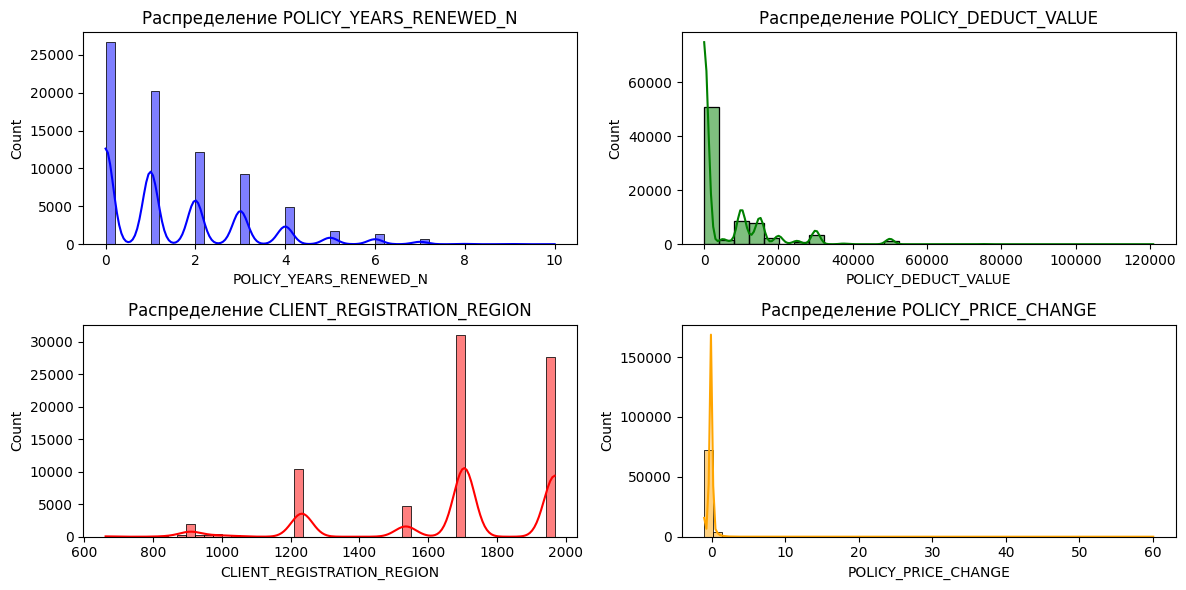

In [108]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
sns.histplot(df['POLICY_YEARS_RENEWED_N'], bins=50, kde=True, color='blue')
plt.title('Распределение POLICY_YEARS_RENEWED_N')

plt.subplot(2, 2, 2)
sns.histplot(df['POLICY_DEDUCT_VALUE'], bins=30, kde=True, color='green')
plt.title('Распределение POLICY_DEDUCT_VALUE')

plt.subplot(2, 2, 3)
sns.histplot(df['CLIENT_REGISTRATION_REGION'], bins=50, kde=True, color='red')
plt.title('Распределение CLIENT_REGISTRATION_REGION')

plt.subplot(2, 2, 4)
sns.histplot(df['POLICY_PRICE_CHANGE'], bins=50, kde=True, color='orange')
plt.title('Распределение POLICY_PRICE_CHANGE')


plt.tight_layout()
plt.show()

Проверяем гипотезу о выбросах в признаке POLICY_MIN_DRIVING_EXPERIENCE

In [109]:
count_values = df['POLICY_MIN_DRIVING_EXPERIENCE'].value_counts().to_frame()
print(count_values.sort_values('POLICY_MIN_DRIVING_EXPERIENCE').to_string(max_rows=20))

                               count
POLICY_MIN_DRIVING_EXPERIENCE       
0                               2570
1                               1450
2                               1559
3                               1590
4                               1757
5                               2237
6                               3017
7                               3242
8                               3067
9                               3361
...                              ...
2006                              28
2007                              21
2008                              24
2009                               9
2010                               4
2011                               7
2012                               7
2013                               3
2014                               4
2015                               4


Отвергаем гипотезу о наличии выбросов - объектов со сходими максимальными значениями (2006-2015) довольно много, количество уменьшается ближе к самой правой границе диапазона значений

Исследуем целевой класс POLICY_IS_RENEWED на сбалансированность

In [110]:
df['POLICY_IS_RENEWED'].value_counts(sort = False)

,count
POLICY_IS_RENEWED,
1,48376
0,29031


Text(0.5, 1.0, 'POLICY_IS_RENEWED')

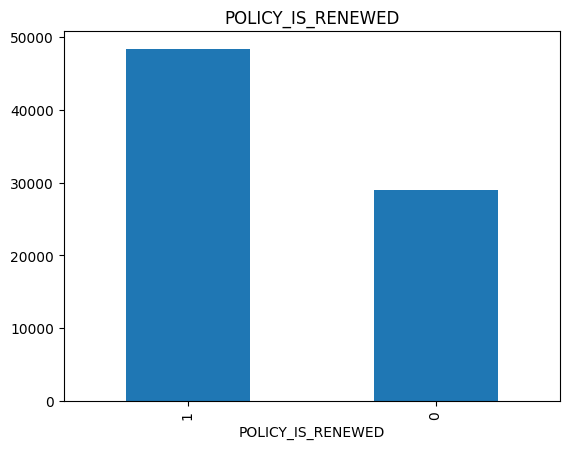

In [111]:
df['POLICY_IS_RENEWED'].value_counts().plot(kind='bar');
plt.title('POLICY_IS_RENEWED')


Наблюдается небольшой дисбаланс классов

Создаем матрицу объект-признак X и вектор с целевой переменной (POLICY_IS_RENEWED) y. Стратифицированная выборка тестового и обучающего датасета

In [112]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn import metrics
import seaborn as sns

In [113]:
from sklearn.model_selection import train_test_split, cross_val_score

X = df.drop("POLICY_IS_RENEWED", axis=1)
y = df["POLICY_IS_RENEWED"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Масштабируем признаки

In [114]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Применим различные модели классификации. Обратим внимание, что в нашем случае будет разный вес ошибок - ошибочно классифицированные как "непродляющие" страховку клиенты, которые впоследствии все-таки продлили ее - это лучше, чем ошибочно предсказанное продление полиса страхования, которое в реальности не состоялось. Будем отражать в настройках моделей дисбаланс классов.

**1. Бустинговая модель классификации CatBoost**

In [115]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.2 MB/s eta 0:00:00


In [116]:
from catboost import CatBoostClassifier

In [117]:
model1 = CatBoostClassifier(iterations=4000, auto_class_weights='SqrtBalanced')
model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)
print(classification_report(y_test, y_pred1))

Learning rate set to 0.015893
0:	learn: 0.6908129	total: 74.8ms	remaining: 4m 59s
1:	learn: 0.6885801	total: 95.6ms	remaining: 3m 11s
2:	learn: 0.6864908	total: 137ms	remaining: 3m 1s
3:	learn: 0.6844273	total: 169ms	remaining: 2m 48s
4:	learn: 0.6825882	total: 198ms	remaining: 2m 38s
5:	learn: 0.6806070	total: 221ms	remaining: 2m 27s
6:	learn: 0.6787855	total: 245ms	remaining: 2m 19s
7:	learn: 0.6769091	total: 266ms	remaining: 2m 12s
8:	learn: 0.6750792	total: 288ms	remaining: 2m 7s
9:	learn: 0.6732800	total: 327ms	remaining: 2m 10s
10:	learn: 0.6716443	total: 374ms	remaining: 2m 15s
11:	learn: 0.6699617	total: 422ms	remaining: 2m 20s
12:	learn: 0.6683373	total: 463ms	remaining: 2m 22s
13:	learn: 0.6667483	total: 501ms	remaining: 2m 22s
14:	learn: 0.6652076	total: 542ms	remaining: 2m 24s
15:	learn: 0.6638452	total: 584ms	remaining: 2m 25s
16:	learn: 0.6623817	total: 635ms	remaining: 2m 28s
17:	learn: 0.6609552	total: 705ms	remaining: 2m 35s
18:	learn: 0.6595192	total: 758ms	remaining:

In [118]:
confusion_mat = confusion_matrix(y_test, y_pred1)
print("Точность:", accuracy_score(y_test, y_pred1))
print("Точность:", precision_score(y_test, y_pred1, average = 'binary'))
print("Полнота:", recall_score(y_test, y_pred1, average = 'binary'))
print("F1-мера:", f1_score(y_test, y_pred1, average = 'binary'))

Точность: 0.7169616328639711
Точность: 0.7456075228903737
Полнота: 0.8304278922345484
F1-мера: 0.7857352413860547


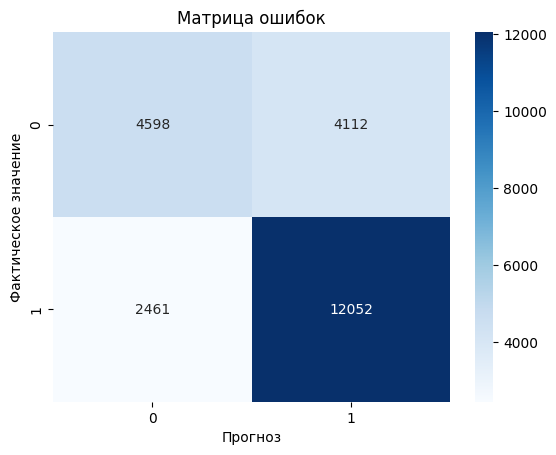

In [119]:
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap = "Blues")
plt.xlabel("Прогноз")
plt.ylabel("Фактическое значение")
plt.title("Матрица ошибок")
plt.show();

**Бэггинг: RandomForestClassifier**

In [120]:
from sklearn.ensemble import RandomForestClassifier

sample_weights = [0.15 if y == 0 else 1 for y in y_train]

model2 = RandomForestClassifier(n_estimators=1000)
model2.fit(X_train, y_train, sample_weight=sample_weights)
y_pred2 = model2.predict(X_test)
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.65      0.49      0.56      8710
           1       0.73      0.85      0.79     14513

    accuracy                           0.71     23223
   macro avg       0.69      0.67      0.67     23223
weighted avg       0.70      0.71      0.70     23223



In [121]:
confusion_mat = confusion_matrix(y_test, y_pred2)
print("Точность:", accuracy_score(y_test, y_pred2))
print("Точность:", precision_score(y_test, y_pred2, average = 'binary'))
print("Полнота:", recall_score(y_test, y_pred2, average = 'binary'))
print("F1-мера:", f1_score(y_test, y_pred2, average = 'binary'))

Точность: 0.7113637342289971
Точность: 0.7332178690874344
Полнота: 0.8459312340660098
F1-мера: 0.785552036343859


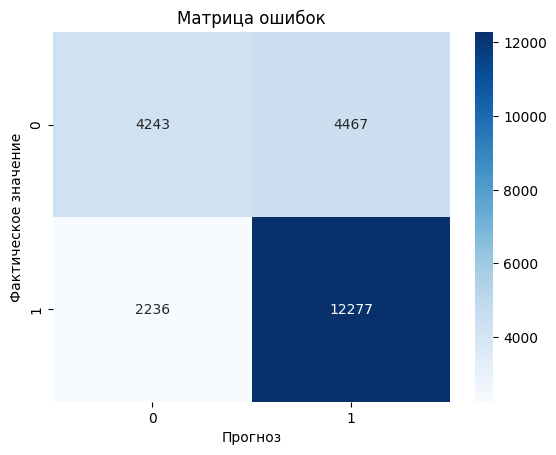

In [122]:
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap = "Blues")
plt.xlabel("Прогноз")
plt.ylabel("Фактическое значение")
plt.title("Матрица ошибок")
plt.show();

Визуализируем важность признаков для предсказания целевого признака:

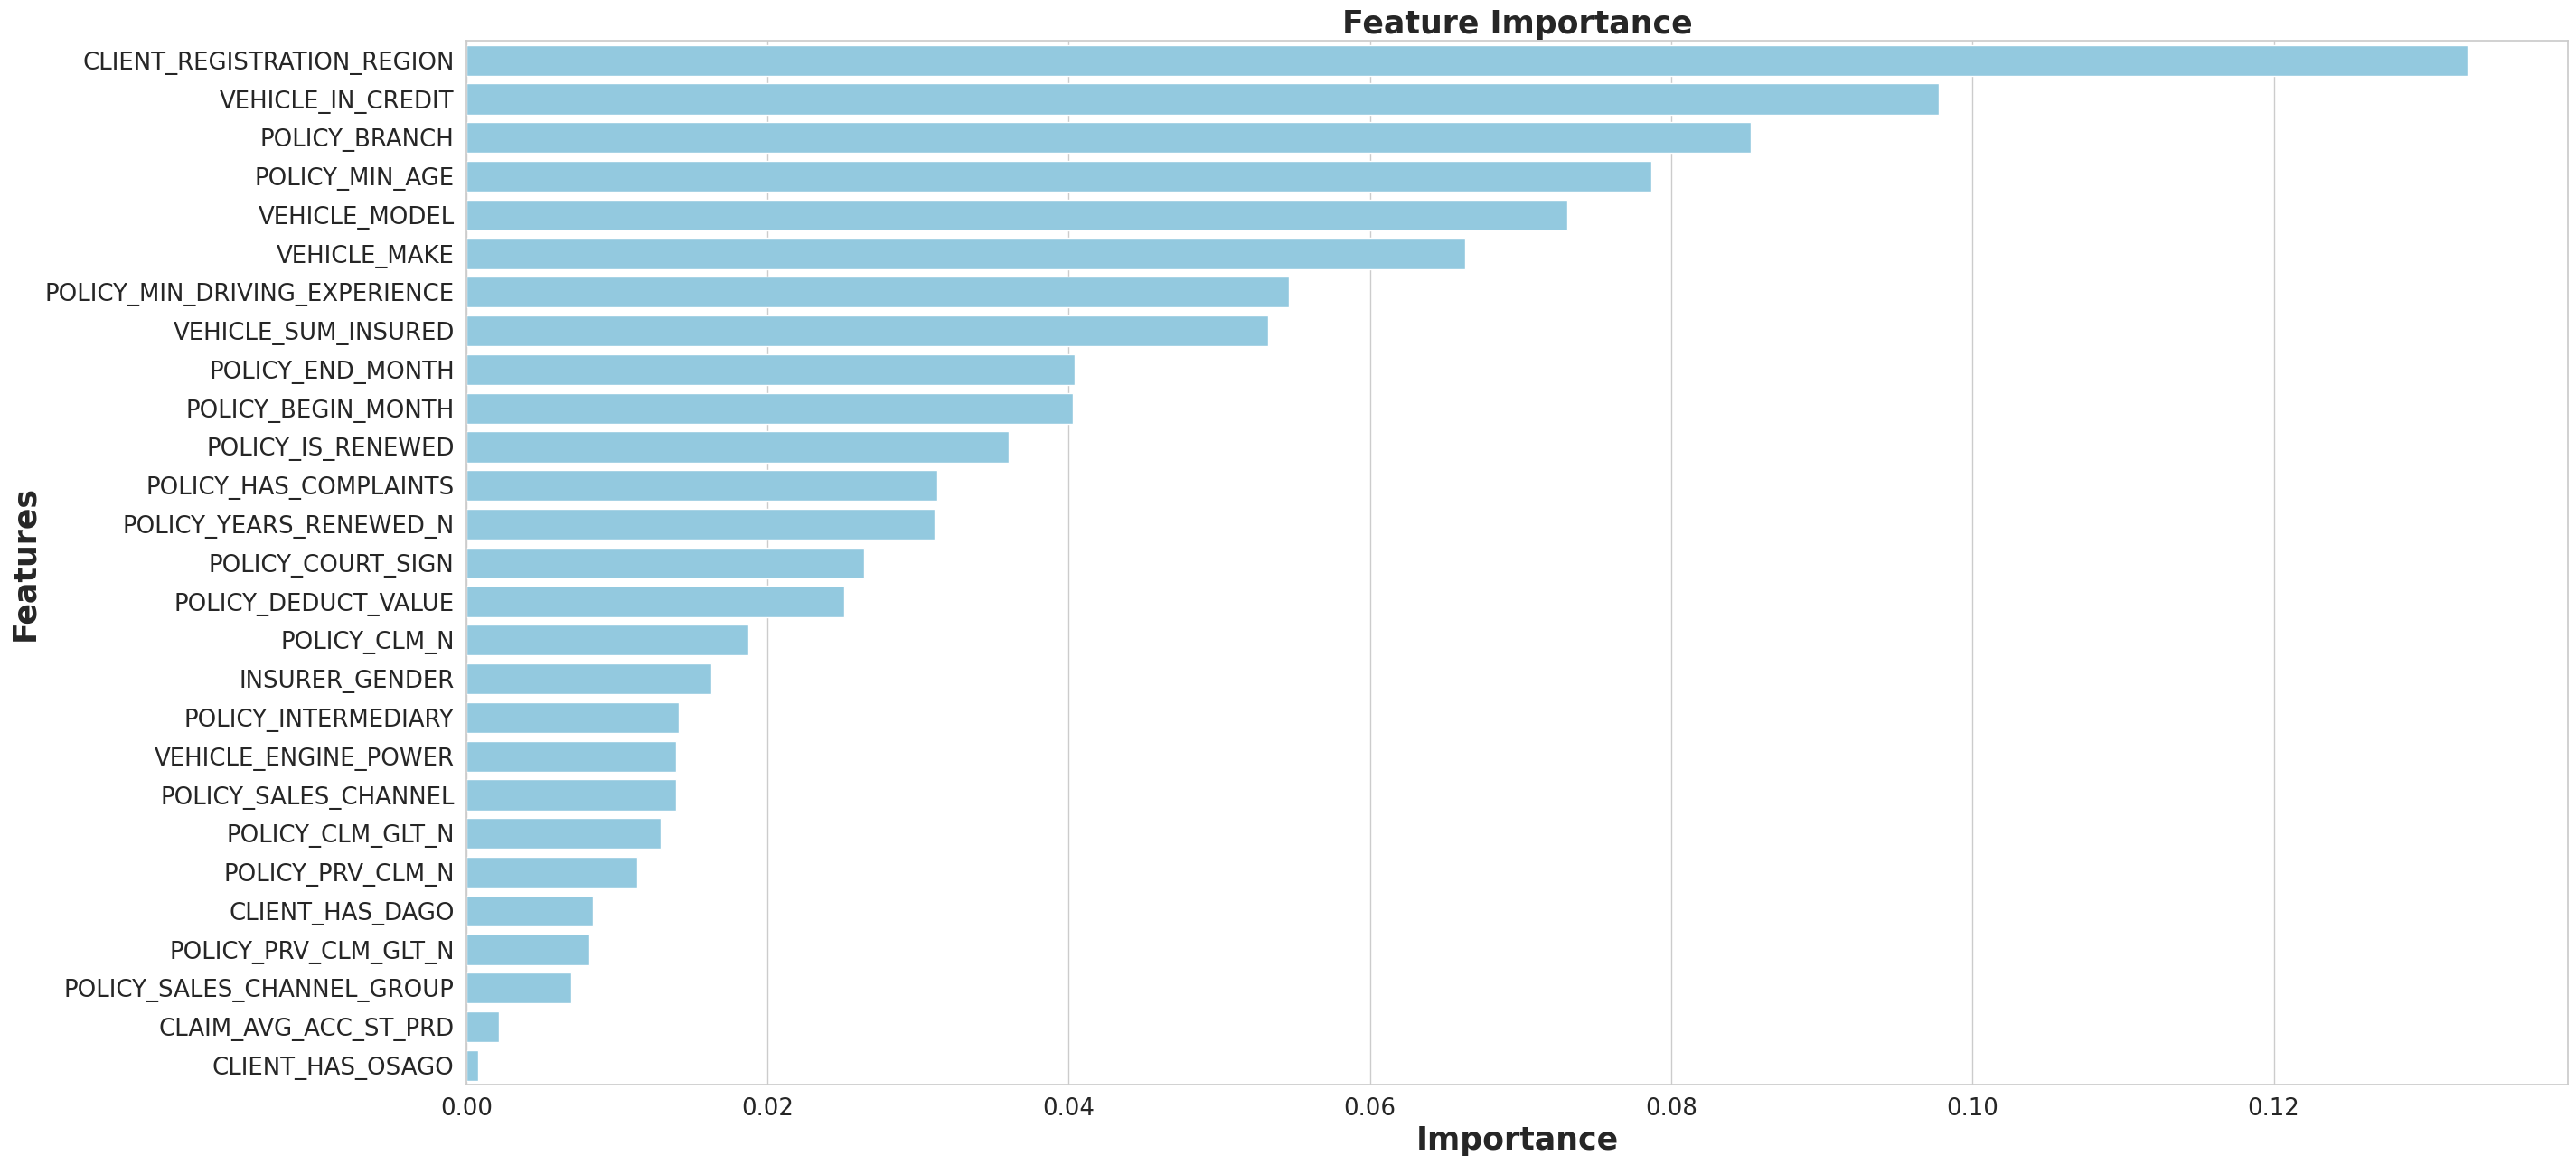

None

,Features,Gini-Importance
0,CLIENT_REGISTRATION_REGION,0.132880
1,VEHICLE_IN_CREDIT,0.097781
2,POLICY_BRANCH,0.085258
3,POLICY_MIN_AGE,0.078655
4,VEHICLE_MODEL,0.073115
5,VEHICLE_MAKE,0.066323
6,POLICY_MIN_DRIVING_EXPERIENCE,0.054587
7,VEHICLE_SUM_INSURED,0.053229
8,POLICY_END_MONTH,0.040380
9,POLICY_BEGIN_MONTH,0.040294


In [123]:
feats = {}
for feature, importance in zip(df.columns, model2.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

Видим, что все перекодированные нами на основе взаимосвязи с целевым признаком категориальные признаки имеют большую важность для модели

**Метод опорных векторов**

In [124]:
from sklearn.svm import SVC

model3 = SVC(max_iter=5000, kernel='linear', class_weight='balanced')

model3.fit(X_train, y_train)
y_pred3 = model3.predict(X_test)
print(classification_report(y_test, y_pred3))

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.41      0.46      0.44      8710
           1       0.65      0.60      0.63     14513

    accuracy                           0.55     23223
   macro avg       0.53      0.53      0.53     23223
weighted avg       0.56      0.55      0.56     23223



In [125]:
confusion_mat = confusion_matrix(y_test, y_pred3)
print("Точность:", accuracy_score(y_test, y_pred3))
print("Точность:", precision_score(y_test, y_pred3, average = 'binary'))
print("Полнота:", recall_score(y_test, y_pred3, average = 'binary'))
print("F1-мера:", f1_score(y_test, y_pred3, average = 'binary'))

Точность: 0.5510485294750893
Точность: 0.652261381417182
Полнота: 0.6031833528560601
F1-мера: 0.6267630844132598


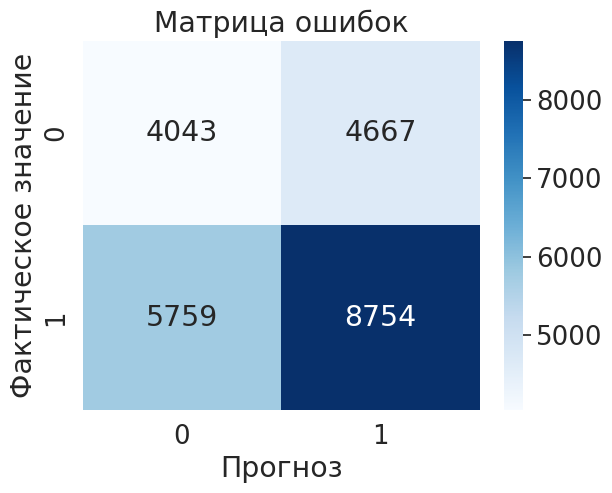

In [126]:
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap = "Blues")
plt.xlabel("Прогноз")
plt.ylabel("Фактическое значение")
plt.title("Матрица ошибок")
plt.show();

**Дерево решений**

In [127]:
from sklearn.tree import DecisionTreeClassifier

model4 = DecisionTreeClassifier(max_depth=10, min_samples_leaf=4, class_weight='balanced')
model4.fit(X_train, y_train)
y_pred4 = model4.predict(X_test)
print(classification_report(y_test, y_pred4))

              precision    recall  f1-score   support

           0       0.57      0.57      0.57      8710
           1       0.74      0.74      0.74     14513

    accuracy                           0.68     23223
   macro avg       0.65      0.65      0.65     23223
weighted avg       0.68      0.68      0.68     23223



In [128]:
confusion_mat = confusion_matrix(y_test, y_pred4)
print("Точность:", accuracy_score(y_test, y_pred4))
print("Точность:", precision_score(y_test, y_pred4, average = 'binary'))
print("Полнота:", recall_score(y_test, y_pred4, average = 'binary'))
print("F1-мера:", f1_score(y_test, y_pred4, average = 'binary'))

Точность: 0.6757524867588167
Точность: 0.7413757345316281
Полнота: 0.7389237235581892
F1-мера: 0.7401476982538477


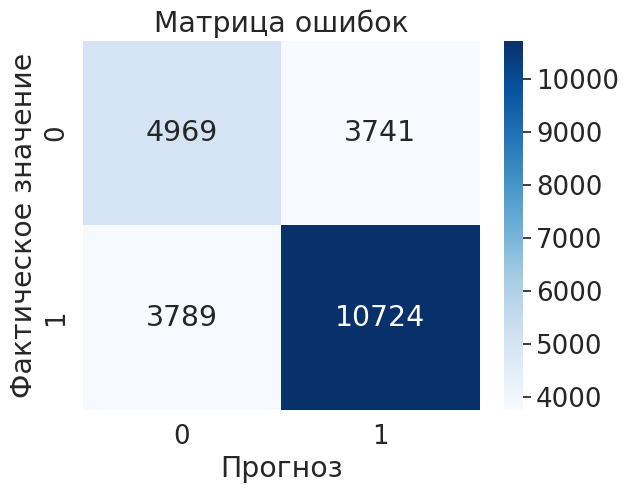

In [129]:
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap = "Blues")
plt.xlabel("Прогноз")
plt.ylabel("Фактическое значение")
plt.title("Матрица ошибок")
plt.show();

**Логистическая регрессия**

In [130]:
from sklearn.linear_model import LogisticRegression

model5 = LogisticRegression(max_iter=1000, class_weight='balanced')
model5.fit(X_train, y_train)
y_pred5 = model5.predict(X_test)
print(classification_report(y_test, y_pred5))

              precision    recall  f1-score   support

           0       0.49      0.55      0.52      8710
           1       0.71      0.66      0.68     14513

    accuracy                           0.62     23223
   macro avg       0.60      0.61      0.60     23223
weighted avg       0.63      0.62      0.62     23223



In [131]:
confusion_mat = confusion_matrix(y_test, y_pred5)
print("Точность:", accuracy_score(y_test, y_pred5))
print("Точность:", precision_score(y_test, y_pred5, average = 'binary'))
print("Полнота:", recall_score(y_test, y_pred5, average = 'binary'))
print("F1-мера:", f1_score(y_test, y_pred5, average = 'binary'))

Точность: 0.618395556129699
Точность: 0.7101212166282442
Полнота: 0.6579618273272239
F1-мера: 0.6830472103004291


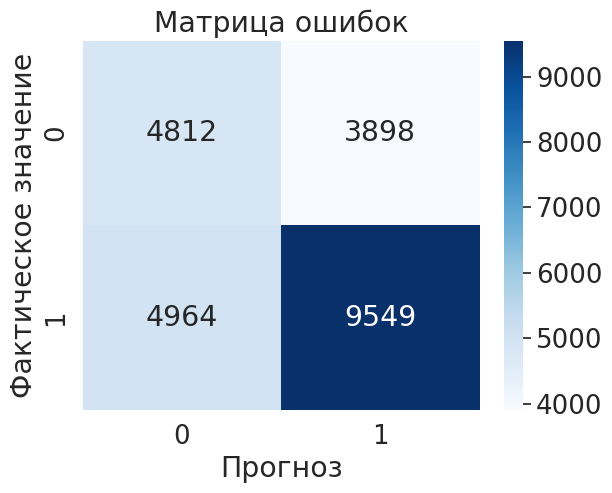

In [132]:
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap = "Blues")
plt.xlabel("Прогноз")
plt.ylabel("Фактическое значение")
plt.title("Матрица ошибок")
plt.show();

**Стэкинговая модель**

Построим двухуровневую модель - на первом, базовом уровне, применим RandomForestClassifer и DecisionTreeClassifier. Надстройкой над ними (моделью второго уровня) будет LogisticRegression

In [133]:
from sklearn.ensemble import StackingClassifier

# Определение базовых моделей
base_models = [
    ('rf', RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced')),
    ('dt', DecisionTreeClassifier(max_depth=9, min_samples_leaf=4, class_weight='balanced'))
    ]

# Создание модели стекинга
model6 = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())
model6.fit(X_train, y_train)

# Предсказания
y_pred6 = model6.predict(X_test)
print(classification_report(y_test, y_pred6))

              precision    recall  f1-score   support

           0       0.69      0.44      0.53      8710
           1       0.72      0.88      0.79     14513

    accuracy                           0.71     23223
   macro avg       0.70      0.66      0.66     23223
weighted avg       0.71      0.71      0.70     23223



In [134]:
confusion_mat = confusion_matrix(y_test, y_pred6)
print("Точность:", accuracy_score(y_test, y_pred6))
print("Точность:", precision_score(y_test, y_pred6, average = 'binary'))
print("Полнота:", recall_score(y_test, y_pred6, average = 'binary'))
print("F1-мера:", f1_score(y_test, y_pred6, average = 'binary'))

Точность: 0.7140765620290229
Точность: 0.7229427422551963
Полнота: 0.8795562599049128
F1-мера: 0.7935965184954927


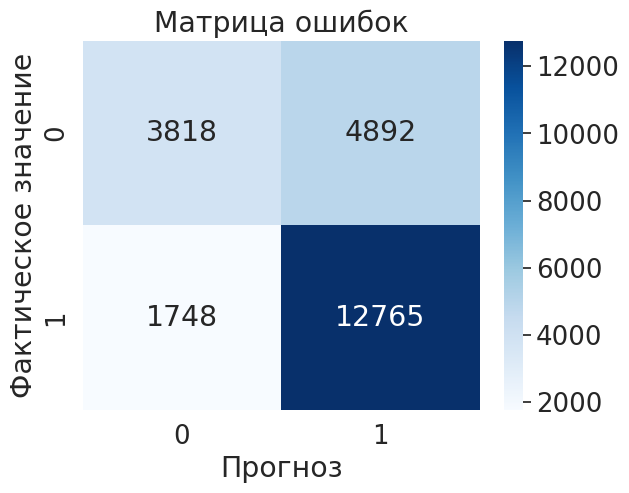

In [135]:
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap = "Blues")
plt.xlabel("Прогноз")
plt.ylabel("Фактическое значение")
plt.title("Матрица ошибок")
plt.show();

По качеству метрик среди использованных нами моделей лучшие результаты показала бустинговая модель CatBoost, RandomForestClassifier и стекинговая модель, т.е. ансамблевые модели. Совсем немного уступила модель DecisionTreeClassifier, но показала при этом существенно лучшие результаты по производительности и скорости, а также наименьшую ошибку прогноза в нужном нам классе (FP - False Positive). Возьмем ее за основу.

**Применим Recursive Feature Elimination (RFE) для выбора количества признаков**

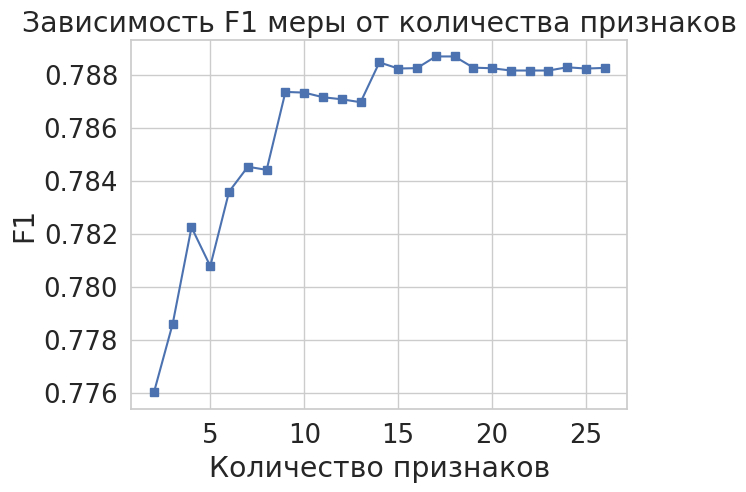

In [136]:
from sklearn.feature_selection import RFE

n_features = list(range(2, len(df.columns)-1))
metrics = []

model7 = DecisionTreeClassifier(max_depth=7, min_samples_leaf=4)

for k in n_features:
  rfe = RFE(model7, n_features_to_select=k)
  rfe = rfe.fit(X_train, y_train)
  X_train_rfe = rfe.transform(X_train)
  X_test_rfe = rfe.transform(X_test)
  model7.fit(X_train_rfe, y_train)
  y_pred7 = model7.predict(X_test_rfe)
  f1 = f1_score(y_test, y_pred7, average = 'binary')
  metrics.append(f1)



plt.plot(n_features, metrics, marker = 's')
plt.title('Зависимость F1 меры от количества признаков')
plt.xlabel('Количество признаков')
plt.ylabel('F1');
plt.show()

По графику можем увидеть, что оптимальным является 14 признаков. После этого качество модели не улучшается

In [137]:
model8 = DecisionTreeClassifier(max_depth=10, min_samples_leaf=4, class_weight='balanced')
rfe = RFE(model8, n_features_to_select=14)
rfe = rfe.fit(X_train, y_train)

In [138]:
# Показываем как признаки отсортированы по важности для модели по RFE:
selected_features = pd.DataFrame({
    'Feature': X.columns,  # Здесь X.columns должен содержать названия столбцов, использованных для X
    'Ranking': rfe.ranking_
})
print(selected_features.sort_values(by='Ranking', ascending=False))

                          Feature  Ranking
22          POLICY_HAS_COMPLAINTS       14
20              POLICY_COURT_SIGN       13
13                 INSURER_GENDER       12
16               POLICY_PRV_CLM_N       11
17           POLICY_PRV_CLM_GLT_N       10
14                   POLICY_CLM_N        9
10              VEHICLE_IN_CREDIT        8
3      POLICY_SALES_CHANNEL_GROUP        7
0              POLICY_BEGIN_MONTH        6
21           CLAIM_AVG_ACC_ST_PRD        5
25     CLIENT_REGISTRATION_REGION        4
6   POLICY_MIN_DRIVING_EXPERIENCE        3
19               CLIENT_HAS_OSAGO        2
9            VEHICLE_ENGINE_POWER        1
24            POLICY_DEDUCT_VALUE        1
23         POLICY_YEARS_RENEWED_N        1
2            POLICY_SALES_CHANNEL        1
4                   POLICY_BRANCH        1
18                CLIENT_HAS_DAGO        1
8                   VEHICLE_MODEL        1
5                  POLICY_MIN_AGE        1
15               POLICY_CLM_GLT_N        1
7          

In [139]:
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)
model8.fit(X_train_rfe, y_train)
y_pred8 = model8.predict(X_test_rfe)
print(classification_report(y_test, y_pred8))

              precision    recall  f1-score   support

           0       0.59      0.55      0.57      8710
           1       0.74      0.77      0.75     14513

    accuracy                           0.69     23223
   macro avg       0.66      0.66      0.66     23223
weighted avg       0.68      0.69      0.68     23223



In [140]:
confusion_mat = confusion_matrix(y_test, y_pred8)
print("Точность:", accuracy_score(y_test, y_pred8))
print("Точность:", precision_score(y_test, y_pred8, average = 'binary'))
print("Полнота:", recall_score(y_test, y_pred8, average = 'binary'))
print("F1-мера:", f1_score(y_test, y_pred8, average = 'binary'))

Точность: 0.6850536106446196
Точность: 0.7394717583660435
Полнота: 0.7658650864741956
F1-мера: 0.7524370430544273


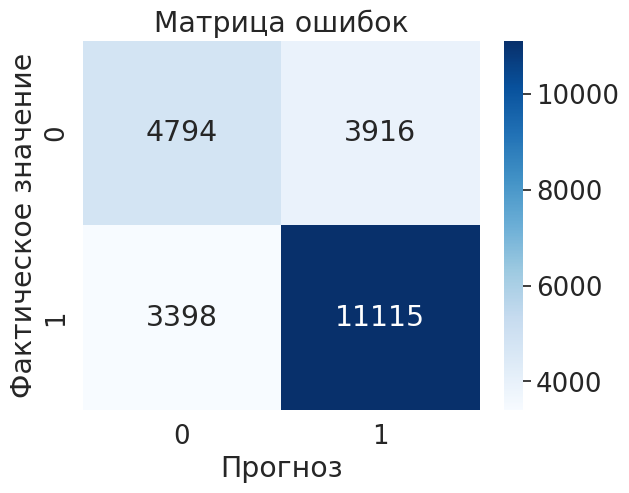

In [141]:
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap = "Blues")
plt.xlabel("Прогноз")
plt.ylabel("Фактическое значение")
plt.title("Матрица ошибок")
plt.show();

Видим, что из всех случаев отказа от продления страхового полиса модель правильно предсказывает 55%. Из всех случаев продления страхового полиса модель правильно предсказала 77% случаев.

**Кросс-валидация**

Оценим модель с найденными гиперпараметрами в случае однократного применения, при 5-кратной кросс-валидации, при 10-кратной кросс-валидации. За основу возьмем значение F1 score.

In [142]:
# Однократная оценка на тестовых данных
single_score = f1_score(y_test, y_pred8, average = 'binary')
print("Однократная оценка эффективности (accuracy):", single_score)

# 5-кратная кросс-валидация на всем датасете
cross_val_scores = cross_val_score(model8, X, y, cv=5, scoring='f1')
print("Среднее значение accuracy по 5-кратной кросс-валидации:", cross_val_scores.mean())

scores_10 = cross_val_score(model8, X, y, cv=10, scoring='f1')
print("Среднее значение accuracy при 10-кратной кросс-валидации:", scores_10.mean())

Однократная оценка эффективности (accuracy): 0.7524370430544273
Среднее значение accuracy по 5-кратной кросс-валидации: 0.74627982535927
Среднее значение accuracy при 10-кратной кросс-валидации: 0.7500519444735515


Можно сделать вывод, что модель не склонна к переобучению - метрика F1 не снижается при 5 либо 10 кратной кросс-валидации

**Выводы**

Исследование данных о  характеристиках страхователей с целью предсказания возможного продления либо отказа от продления страхового полиса ОСАГО позволило построить модели машинного обучения с хорошими предсказателными способностями. В рамках исследования была проведена работа с категориальными признаками: кодировка осуществлялась исходя из корреляции с целевым признаком; были построены различные модели классификации, определены параметры точности по каждой модели, выбрана оптимальная модель для прогнозирования целевого признака. С помощью кросс-валидации была проверена гипотеза о стабильности модели и отсуствии переобучения, с помощью метода RFE определено оптимальное количество признаков, необходимых для точного прогнозирования целевого параметра.
Результаты исследования могут быть полезны для формулирования управленческих задач специалистов по привлечению клиентов в страховой компании, определения маркетинговой политики, формирования ценовой политики страховой компании.